
# WC2 팀 

▣ 목표
> 과거 구매 이력과 현재 구매 정보를 활용하여, 과거 구매 상품 중 현재 재구매 할 만한 상품을 제안 (예측)

▣ 목차
>  1. 데이터로드
>  2. EDA
>  3. F1 SCORE
>  4. 협업필터링
>  5. 로지스틱모델
>  6. SVD
>  7. 결과
> → 협업필터링으로 최종 사용

▣ 참고
1. 노트북의 각 Cell은 위에서 아래로 순차적 실행 순서에 따라 배치한다.
 - 순서대로 실행 시 노트북의 모든 내용이 재현 가능해야 함.
 - 노트북 내용의 이해를 위해 Markdown을 활용한 충분한 설명을 덧붙인다.

2. 추가 설명 없이 노트북만으로 분석 내용을 이해할 수 있도록 함.
  - Markdown 사용은 자유형식이나, 분석 개요와 각 부분별 큰 제목/소제목/부분요약 등을 # number sign으로 heading 처리하여 목차를 생성함.
3. 다양한 분석을 시도하되 논리적인 전개 흐름을 유지하여 분석 결과를 작성한다.
4. 독창적인 분석 시도에 대한 배점이 있으므로, 웹상의 기존 분석 코드들을 그대로 적용하기 보다 창의력을 발휘하여 문제에 도전한다.
5. 노트북 파일명은 안내된 규칙대로 명명하며, 제출용 노트북은 단일 노트북으로 작성한다.
 - 여러 분석 노트북으로 작업했더라도 결과 노트북은 규칙대로 명명한 하나의 노트북으로 제출함.


---

## 데이터로드

In [419]:
## Set Package
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from jbfg.pandas_utils import *

In [5]:
## Set
schema = 'l2_jbwc_extnl'

### Product info
> 기본 데이터 명세

In [18]:
s1 = 'SELECT * FROM products_info'
df_products_info = get_df(s1,schema)
df_products_info.head()

,product_id,name,category_id,division_id,category_name,division_name
0,21709,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
1,20995,Organic Broccoli Florets,116,1,frozen produce,frozen
2,33000,Pure Irish Butter,36,16,butter,dairy eggs
3,7781,Organic Sticks Low Moisture Part Skim Mozzarel...,21,16,packaged cheese,dairy eggs
4,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs


- division > category > product 단위로 구성되어있음

In [653]:
df_products_info.describe()

,product_id,name,category_id,division_id,category_name,division_name
count,100,100,100,100,100,100
unique,100,100,21,9,21,9
top,9839,Organic Garlic,83,4,fresh vegetables,produce
freq,1,1,29,67,29,67


- division 9개 / category 21개 / product 100개

In [654]:
# division / category 구성 검토
df_products_info.groupby(['division_name','category_name'])['product_id'].count()

division_name  category_name                
bakery         bread                             1
beverages      refrigerated                      1
               soft drinks                       1
               water seltzer sparkling water     5
canned goods   canned meals beans                1
dairy eggs     butter                            2
               cream                             2
               eggs                              2
               milk                              5
               packaged cheese                   4
               soy lactosefree                   3
deli           fresh dips tapenades              1
               lunch meat                        1
frozen         frozen produce                    2
meat seafood   packaged poultry                  1
pantry         oils vinegars                     1
produce        fresh fruits                     24
               fresh herbs                       3
               fresh vegetables      

- division이 produce(농산품)인 상품이 가장 많으며, fresh fruits(과일)/fresh vegetables(채소)가 가장 많이 있음  

In [655]:
print('division : ',df_products_info.division_name.unique())
print('\n category : ',df_products_info.category_name.unique())

division :  ['beverages' 'frozen' 'dairy eggs' 'produce' 'canned goods' 'deli'
 'pantry' 'meat seafood' 'bakery']

 category :  ['water seltzer sparkling water' 'frozen produce' 'butter'
 'packaged cheese' 'soy lactosefree' 'fresh vegetables' 'fresh fruits'
 'milk' 'soft drinks' 'refrigerated' 'canned meals beans'
 'packaged vegetables fruits' 'eggs' 'lunch meat' 'fresh herbs'
 'packaged produce' 'oils vinegars' 'packaged poultry' 'bread' 'cream'
 'fresh dips tapenades']


### Train_x_past

#### Train_x_past 전처리
> 5,859명 고객들의 과거 구매이력 + 제품정보 병합

In [325]:
### trian_X_past 로드 : 편의상 상품 아이디 대신 이름을 함께 매핑하여 붙임
s2 = '''select  a.*
        , b.division_name
        , b.category_name
        , b.name        
from   l2_jbwc_extnl.train_x_past a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id

order by order_hour
'''
train_X_past = get_df(s2,schema)
train_X_past.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,division_name,category_name,name
0,370178,10757,23,6,0,13.0,7,1,26209,produce,fresh fruits,Limes
1,524817,116565,6,4,0,6.0,5,1,28985,produce,fresh vegetables,Michigan Organic Kale
2,397948,203399,67,0,0,3.0,12,1,49683,produce,fresh vegetables,Cucumber Kirby
3,370178,10757,23,6,0,13.0,1,1,45066,produce,fresh fruits,Honeycrisp Apple
4,2381084,10757,30,0,0,9.0,3,1,49235,dairy eggs,cream,Organic Half & Half


In [657]:
print(train_X_past.info())
print(train_X_past.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253972 entries, 0 to 1253971
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1253972 non-null  object
 1   cstno           1253972 non-null  object
 2   order_number    1253972 non-null  object
 3   week_day        1253972 non-null  object
 4   order_hour      1253972 non-null  object
 5   order_interval  1253972 non-null  object
 6   add_order       1253972 non-null  object
 7   is_reordered    1253972 non-null  object
 8   product_id      1253972 non-null  object
 9   division_name   1253972 non-null  object
 10  category_name   1253972 non-null  object
 11  name            1253972 non-null  object
dtypes: object(12)
memory usage: 114.8+ MB
None
       order_id    cstno order_number week_day order_hour order_interval  \
count   1253972  1253972      1253972  1253972    1253972        1253972   
unique   341678     5859           99      

- 대부분 object(문자열베이스)로 정렬이 잘 안될수 있으므로 order_hour(주문시간), order_interval(직전구매후 경과일수), 주문서 내 순번 등은 숫자형으로 변환해야할 듯

> order_hour(주문시간), order_interval(직전구매후 경과일수), 주문서 내 순번 등 숫자형 변환 과정

In [326]:
## 형변환전 정렬되나 확인
## add_order(주문서내 담긴순번) 정렬시 1→ 11 ,,, 이렇게 정렬
train_X_past[train_X_past.order_id == '2538975'].sort_values(by = 'add_order')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,division_name,category_name,name
708559,2538975,189909,70,0,16,18.0,1,1,21903,produce,packaged vegetables fruits,Organic Baby Spinach
709432,2538975,189909,70,0,16,18.0,11,1,47209,produce,fresh fruits,Organic Hass Avocado
702477,2538975,189909,70,0,16,18.0,12,1,8174,produce,fresh fruits,Organic Navel Orange
701789,2538975,189909,70,0,16,18.0,13,0,9839,produce,fresh vegetables,Organic Broccoli
702131,2538975,189909,70,0,16,18.0,14,1,37646,produce,fresh fruits,Organic Gala Apples
709007,2538975,189909,70,0,16,18.0,19,1,21137,produce,fresh fruits,Organic Strawberries
709227,2538975,189909,70,0,16,18.0,2,1,13176,produce,fresh fruits,Bag of Organic Bananas
701749,2538975,189909,70,0,16,18.0,26,1,3957,beverages,refrigerated,100% Raw Coconut Water
702515,2538975,189909,70,0,16,18.0,28,1,35221,beverages,water seltzer sparkling water,Lime Sparkling Water
702459,2538975,189909,70,0,16,18.0,29,1,31506,pantry,oils vinegars,Extra Virgin Olive Oil


In [327]:
## 형변환 후 다시 추출
s2 = '''select  a.order_id, cstno
        , cast(order_number as integer) as order_number
        , cast(week_day as integer) as week_day
        , cast(order_hour as integer) as order_hour
        , order_interval
        , cast(add_order as integer) as add_order
        , cast(is_reordered as integer) as is_reordered 
        , b.division_name
        , b.category_name
        , b.name        
from   l2_jbwc_extnl.train_x_past a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id

'''
train_X_past = get_df(s2,schema)
train_X_past.head()

# 누리변경 is_reordered >  cast(is_reordered as integer) as is_reordered 

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,division_name,category_name,name
0,717029,196613,15,1,9,3.0,5,0,produce,fresh vegetables,Organic Romaine Lettuce
1,2325772,196613,35,6,11,2.0,7,1,produce,fresh vegetables,Organic Romaine Lettuce
2,642668,196613,69,2,16,2.0,11,1,dairy eggs,milk,Whole Milk
3,1326515,196613,61,3,19,3.0,3,1,dairy eggs,milk,Whole Milk
4,1437845,196613,36,3,15,4.0,16,0,dairy eggs,milk,Whole Milk


In [660]:
## 형변환 재확인 (변환됨)
train_X_past.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253972 entries, 0 to 1253971
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1253972 non-null  object
 1   cstno           1253972 non-null  object
 2   order_number    1253972 non-null  int64 
 3   week_day        1253972 non-null  int64 
 4   order_hour      1253972 non-null  int64 
 5   order_interval  1253972 non-null  object
 6   add_order       1253972 non-null  int64 
 7   is_reordered    1253972 non-null  int64 
 8   division_name   1253972 non-null  object
 9   category_name   1253972 non-null  object
 10  name            1253972 non-null  object
dtypes: int64(5), object(6)
memory usage: 105.2+ MB


#### Train_x_past 상세
> 특정 주문서 및 고객 명세

In [661]:
## 주문서 샘플 검토
train_X_past[train_X_past.order_id == '2538975'].sort_values(by = 'add_order')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,division_name,category_name,name
1017052,2538975,189909,70,0,16,18.0,1,1,produce,packaged vegetables fruits,Organic Baby Spinach
1017116,2538975,189909,70,0,16,18.0,2,1,produce,fresh fruits,Bag of Organic Bananas
1016834,2538975,189909,70,0,16,18.0,3,1,produce,fresh vegetables,Organic Small Bunch Celery
1016748,2538975,189909,70,0,16,18.0,5,1,produce,fresh vegetables,Organic Garnet Sweet Potato (Yam)
1016859,2538975,189909,70,0,16,18.0,7,1,produce,fresh vegetables,Fresh Cauliflower
1017020,2538975,189909,70,0,16,18.0,11,1,produce,fresh fruits,Organic Hass Avocado
1016676,2538975,189909,70,0,16,18.0,12,1,produce,fresh fruits,Organic Navel Orange
1016666,2538975,189909,70,0,16,18.0,13,0,produce,fresh vegetables,Organic Broccoli
1016878,2538975,189909,70,0,16,18.0,14,1,produce,fresh fruits,Organic Gala Apples
1017075,2538975,189909,70,0,16,18.0,19,1,produce,fresh fruits,Organic Strawberries


- 한 주문서 내에서도 add_order(장바구니 담은 순서)에 없는 숫자들이 있음 (넣었다가 안산 것도 반영되는것으로 보임)
- 같은 주문서 2538975 내의 order_interval(직전구매이후 경과일수)가 같음 (상품 단이 아니라 고객번호 단위인 것으로 보임)
- is_reorderd(재구매여부) :  1 = 재구매 / 0 = 최초구매 (고객기준 다음 상품기준으로 반영)

> 고객별 총 주문수 / 구매 상품수

In [662]:
print('[고객별 순수 주문수]\n',train_X_past.pivot_table('order_id', index = 'cstno', aggfunc = 'nunique').sort_values('order_id', ascending = False))
print('\n[고객별 주문 수]\n',train_X_past.pivot_table('order_id', index = 'cstno', aggfunc = 'count').sort_values('order_id', ascending = False))
print('\n[고객별 주문 상품수]\n',train_X_past.pivot_table('name', index = 'cstno', aggfunc = 'nunique').sort_values('name', ascending = False))

[고객별 순수 주문수]
         order_id
cstno           
164055        99
143352        99
71049         99
6710          99
95967         99
...          ...
191211        42
108401        42
191375        42
191735        42
75532         42

[5859 rows x 1 columns]

[고객별 주문 수]
         order_id
cstno           
150840       795
184451       766
103593       762
100787       751
54485        745
...          ...
41413         46
167031        45
117338        44
73719         43
16883         42

[5859 rows x 1 columns]

[고객별 주문 상품수]
         name
cstno       
5557      71
182401    68
105168    61
169226    60
148812    60
...      ...
41413      1
15182      1
133105     1
84627      1
16883      1

[5859 rows x 1 columns]


- 고객 최대 순수주문은 99회, 제일많이 구매한 고객은 최대 795번 구매함, 가장많은 품목을 구매한 고객은 71개

>제일 많이 물건을 구매한 고객 '150840' 분석 

In [663]:
# 제일 많이 상품을 구매한 id : 150840 명세
print("총 주문상품수: ",len(train_X_past[train_X_past.cstno=='150840']))
print("총 주문횟수: ",len(train_X_past[train_X_past.cstno=='150840'].sort_values('order_id', ascending = False).pivot_table('cstno', index = 'order_id', aggfunc = 'count').sort_values('order_id', ascending = False)))
print("주문횟수 中 바나나 주문횟수: ",len(train_X_past.loc[(train_X_past.cstno=='150840')&(train_X_past.name=='Banana'),:]))
print("\n<상위 구문수 상품>")
train_X_past.loc[(train_X_past.cstno=='150840')].pivot_table('cstno',index='name',aggfunc='count').sort_values('cstno', ascending = False).head()

총 주문상품수:  795
총 주문횟수:  99
주문횟수 中 바나나 주문횟수:  80

<상위 구문수 상품>


,cstno
name,
Banana,80
Limes,62
Organic Baby Spinach,61
Carrots,55
Extra Virgin Olive Oil,45


- 주문횟수가 99개인데 이중 Banana구매가 80회;

In [664]:
train_X_past.loc[(train_X_past.cstno=='150840')].pivot_table('cstno',index='category_name',aggfunc='count').sort_values('cstno', ascending = False).head()

,cstno
category_name,
fresh vegetables,291
fresh fruits,251
packaged vegetables fruits,110
oils vinegars,45
fresh dips tapenades,42


- 총 주문상품 795 중 fresh 제품 50% 넘어감 (채식주의자인감ㅋㅋ.ㅋㅋ...)

In [665]:
# Banana 주문서로만 구매순서대로 나열
train_X_past.loc[(train_X_past.cstno=='150840')&(train_X_past.name=='Banana'),"order_id":"is_reordered"].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
789081,2568475,150840,1,5,15,,2,0
789049,1175381,150840,2,0,10,2.0,10,1
789076,2436311,150840,3,0,18,0.0,35,1
789075,2421790,150840,4,5,8,5.0,23,1
789031,565420,150840,5,0,7,2.0,4,1
789085,2799109,150840,7,1,11,1.0,16,1
789042,967438,150840,8,6,8,5.0,4,1
789069,2051396,150840,9,6,11,0.0,15,1
789038,818709,150840,10,6,12,0.0,1,1
789051,1196976,150840,12,1,11,2.0,5,1


- order_interval(주문간격): 첫 구매시 na, 당일날 2번 주문하는 경우 0

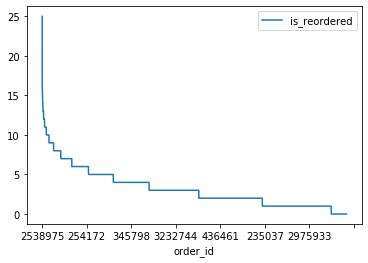

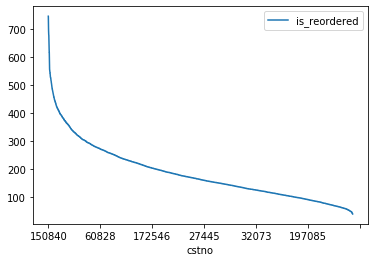

In [666]:
# 주문서별 최대 재구매 항목
a = train_X_past.pivot_table('is_reordered', index = 'order_id', aggfunc = 'sum').sort_values('is_reordered', ascending = False)
a.plot()
# 고객별 최대 재구매 항목
train_X_past.pivot_table('is_reordered', index = 'cstno', aggfunc = 'sum').sort_values('is_reordered', ascending = False).plot()

- 주문서별 5건정도는 재구매!? / 고객별 재구매항목 개수는 100개 이상정도

In [667]:
# 고객별 구매상품중
test_tmp = pd.DataFrame(columns = ["cstno","percent"])
test_tmp["cstno"] = (train_X_past.pivot_table('is_reordered', index = 'cstno', aggfunc = 'sum').is_reordered/train_X_past.pivot_table('order_id', index = 'cstno', aggfunc = 'count').order_id).index
test_tmp["percent"] = (train_X_past.pivot_table('is_reordered', index = 'cstno', aggfunc = 'sum').is_reordered/train_X_past.pivot_table('order_id', index = 'cstno', aggfunc = 'count').order_id).values
# test_tmp = ["cstno"] = (train_X_past.pivot_table('is_reordered', index = 'cstno', aggfunc = 'sum').is_reordered/train_X_past.pivot_table('order_id', index = 'cstno', aggfunc = 'count').order_id).cstno
test_tmp.sort_values('percent', ascending = False)

,cstno,percent
5852,99753,0.989529
1645,15182,0.986667
3118,199091,0.985507
5543,90110,0.984848
5285,82414,0.984733
...,...,...
1506,147358,0.617021
2906,191846,0.615385
4583,59830,0.600000
1895,159779,0.576087


- 고객별 구매항목 中 재구매 항목비율 98%~53% (샀던것들 중에서 사나보다.. 재구매확률 중요해보임)

In [668]:
print("id:99753 의 총 주문품목: ",len(train_X_past[train_X_past.cstno=='99753']))
print("id:99753 의 주문횟수: ",len(train_X_past[train_X_past.cstno=='99753'].sort_values('order_id', ascending = False).pivot_table('cstno', index = 'order_id', aggfunc = 'count').sort_values('order_id', ascending = False)))
print("id:99753 의 Organic Whole Milk 주문횟수: ",len(train_X_past.loc[(train_X_past.cstno=='99753')&(train_X_past.name=='Organic Whole Milk'),:]))
train_X_past.loc[(train_X_past.cstno=='99753')].pivot_table('cstno',index='name',aggfunc='count').sort_values('cstno', ascending = False).head()
# train_X_past[train_X_past.cstno=='150840'].pivot_table('cstno', 
#                                                        index = 'name',
#                                                        # columns ='name',
#                                                        # 'division_name','category_name','name'
#                                                        aggfunc = 'count').sort_values('order_id', ascending = False)

id:99753 의 총 주문품목:  191
id:99753 의 주문횟수:  99
id:99753 의 Organic Whole Milk 주문횟수:  96


,cstno
name,
Organic Whole Milk,96
Organic Reduced Fat Milk,95


- cstno 5852 가 재구매확률 약 99% 왜일까 보니 2개 항목만 구매함

#### Train_x_current + Train_y
 > 5,859명의 구매목록리스트 ( 한명당 한번의 주문o 두번주문x )
 > - 고객 1명의 n개 구매항목을 추천하면 되지 않을까? ( n개의 구매순서목록 = n개의 상품 순서대로 추천 ) > 결론 : eda를 통해 안하기로 결정

In [315]:
## train_x_current
nuri_1 = ''' 
select  order_id, cstno
        , cast(order_number as integer) as order_number
        , cast(week_day as integer) as week_day
        , cast(order_hour as integer) as order_hour
        , order_interval
        , cast(add_order as integer) as add_order
        , cast(is_reordered as integer) as is_reordered
        , 1 as cnt
from    l2_jbwc_extnl.train_x_current 

'''
eda_ty_current = get_df(nuri_1,schema)
eda_ty_current

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,cnt
0,806422,41116,47,5,18,3.0,4,1,1
1,2146033,127113,45,1,10,7.0,24,1,1
2,3055498,140168,45,5,10,26.0,11,1,1
3,3267527,60604,52,0,16,8.0,2,1,1
4,3125992,136554,46,4,9,5.0,2,0,1
...,...,...,...,...,...,...,...,...,...
24419,3184000,174046,100,5,7,2.0,12,1,1
24420,1754722,6710,100,5,11,3.0,21,1,1
24421,1076973,150840,100,0,13,0.0,18,1,1
24422,1247049,99707,100,1,13,3.0,6,1,1


In [316]:
## 보기 편리하게 가공
nuri_2 = ''' 
select  a.*
        , b.division_name
        , b.category_name
        , b.name
from   (
    select  a.*            
    from    l2_jbwc_extnl.train_y a
    where 1 = 1 
) a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id

'''
eda_ty_current_y = get_df(nuri_2,schema)
eda_ty_current_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     24424 non-null  object
 1   division_name  24424 non-null  object
 2   category_name  24424 non-null  object
 3   name           24424 non-null  object
dtypes: object(4)
memory usage: 763.4+ KB


In [317]:
eda_ty_current["division_name"] = eda_ty_current_y["division_name"]
eda_ty_current["category_name"] = eda_ty_current_y["category_name"]
eda_ty_current["name"] = eda_ty_current_y["name"]
eda_ty_current

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,cnt,division_name,category_name,name
0,806422,41116,47,5,18,3.0,4,1,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
1,2146033,127113,45,1,10,7.0,24,1,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
2,3055498,140168,45,5,10,26.0,11,1,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
3,3267527,60604,52,0,16,8.0,2,1,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
4,3125992,136554,46,4,9,5.0,2,0,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
...,...,...,...,...,...,...,...,...,...,...,...,...
24419,3184000,174046,100,5,7,2.0,12,1,1,produce,fresh fruits,Banana
24420,1754722,6710,100,5,11,3.0,21,1,1,produce,fresh fruits,Banana
24421,1076973,150840,100,0,13,0.0,18,1,1,produce,fresh fruits,Banana
24422,1247049,99707,100,1,13,3.0,6,1,1,produce,fresh fruits,Banana


In [672]:
eda_ty_current.pivot_table('cnt', index = ['cstno','order_id'], aggfunc = 'sum').sort_values(['cstno','order_id'])

,,cnt
cstno,order_id,
10000,1925217,1
100001,805264,9
100046,403619,2
100071,3284682,7
100108,2321943,3
...,...,...
9981,144242,3
99829,1592746,2
99887,1668158,9


- 주문서 순서별 다르게 추천해서 정확도를 높이려면 추천목록이 정확할 것이 필수로 보여짐.. 그게 아니라면 한개 상품을 일관적으로 추천하는 것이 정확도측면에서 더 높을수도
- 주문서 상품들의 교집합으로 정확도를 계산하는게 아니니 주문서별 담는 순서별 정확하게 추천해줘야하는데 아래를 보면.. 보통은 Organic Whole Milk>Organic Reduced Fat Milk 담는 순서지만 꼭 그렇지도 않음
- 결론, 다르게 추천하기보단 좀 무식하지만 정확한 한가지를 추천해서 정확도를 높이는게 나을 것 같다. (현실적으로,, 어떤 변수가 영향을 주는지 모르겠슴)

In [673]:
eda_ty_current.loc[(eda_ty_current.cstno=='99753')].sort_values('add_order')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,cnt,division_name,category_name,name
17401,3143182,99753,100,1,8,5.0,1,1,1,dairy eggs,milk,Organic Whole Milk
906,3143182,99753,100,1,8,5.0,2,1,1,dairy eggs,milk,Organic Reduced Fat Milk


In [674]:
train_X_past.loc[(train_X_past.cstno=='99753')].sort_values('order_id', ascending = False).head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,division_name,category_name,name
67391,884531,99753,96,1,14,3.0,1,1,dairy eggs,milk,Organic Whole Milk
67297,884531,99753,96,1,14,3.0,2,1,dairy eggs,milk,Organic Reduced Fat Milk
67296,826626,99753,59,3,12,2.0,1,1,dairy eggs,milk,Organic Reduced Fat Milk
67390,826626,99753,59,3,12,2.0,2,1,dairy eggs,milk,Organic Whole Milk
67389,798001,99753,13,2,7,4.0,1,1,dairy eggs,milk,Organic Whole Milk
67295,798001,99753,13,2,7,4.0,2,1,dairy eggs,milk,Organic Reduced Fat Milk
67388,781525,99753,69,5,7,2.0,1,1,dairy eggs,milk,Organic Whole Milk
67294,781525,99753,69,5,7,2.0,2,1,dairy eggs,milk,Organic Reduced Fat Milk
67387,761914,99753,42,1,10,4.0,2,1,dairy eggs,milk,Organic Whole Milk
67293,761914,99753,42,1,10,4.0,1,1,dairy eggs,milk,Organic Reduced Fat Milk


### 기타테이블 생략
> 변수명이 같은 것으로 보아 비슷한 구조가 예상되므로 일단 생략

---

## EDA

> 데이터 로드 -- 보기편리하게 가공

In [324]:
## 보기 편리하게 가공
s3 = ''' 
select  a.order_id, cstno
        , cast(order_number as integer) as order_number
        , cast(week_day as integer) as week_day
        , cast(order_hour as integer) as order_hour
        , order_interval
        , cast(add_order as integer) as add_order
        , is_reordered
        , a.product_id
        , a.order_rn
        , a.add_rn
        , b.division_name
        , b.category_name
        , b.name
        , 1 as cnt
from   (
    select  a.*,
            dense_rank() OVER (PARTITION BY cstno ORDER BY cast(order_number as integer)  ASC)     AS order_rn,
            row_number() OVER (PARTITION BY cstno, order_id ORDER BY cast(add_order as integer) ASC)     AS add_rn
            
    from    l2_jbwc_extnl.train_x_past a
    where 1 = 1 
    order by order_rn, add_rn
) a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id

order by order_hour
'''
TX_PAST = get_df(s3,schema)

### 상품별 구매횟수

In [19]:
# 상품 별 구매횟수
b1 = pd.DataFrame(columns = ["division_name","category_name","name","cnt"])
b1["division_name"] =  df_products_info["division_name"]
b1["category_name"] =  df_products_info["category_name"]
b1["name"] =  df_products_info["name"]

group_txpp = TX_PAST.groupby(['name']).count()

j = 0
for i in df_products_info.name : # i = 물건이름 string
    b1.cnt.loc[j] = group_txpp[group_txpp.index == i].order_id[0]
    j = j+1

b1= b1.sort_values(by = 'cnt', ascending = False)
b1['rate'] = b1['cnt']/sum(b1.cnt)*100          ## 전체 구매횟수중에 물건별 구매비중

In [719]:
pd.set_option('max_rows',100)
b1

,division_name,category_name,name,cnt,rate
99,produce,fresh fruits,Banana,74686,5.95595
98,produce,fresh fruits,Bag of Organic Bananas,67514,5.38401
97,produce,fresh fruits,Organic Strawberries,52917,4.21995
95,produce,fresh fruits,Organic Hass Avocado,42604,3.39752
96,produce,packaged vegetables fruits,Organic Baby Spinach,40112,3.1988
90,dairy eggs,milk,Organic Whole Milk,29757,2.37302
89,produce,packaged vegetables fruits,Organic Raspberries,28207,2.24941
94,produce,fresh fruits,Organic Avocado,25046,1.99733
91,produce,fresh fruits,Limes,21216,1.6919
93,produce,fresh fruits,Large Lemon,21012,1.67564


- 바나나 젤많이 구매하고,,ㅋ, ,,건수때문에 왜곡이 있어서 그렇지, 비율로 보았을 때 상위 10개정도 제품 제외하고는 구매비율 비슷함

- 하위 50개 상품의 전체 비중을 알아보니 25.20 %

In [495]:
b2 = b1[51:100]
sum(b2.rate)

25.19729308150422

#### 상위 상품 N개 RATE
> 상위 N개 상품으로만 모델링할 수 있도록 RATE 생성

> 상위 상품에 구매가 몰려있으니 집중해서 볼 예정

In [493]:
TX_PAST_50 = TX_PAST

In [496]:
# 하위 50개 상품 제거
for i in b2.name : 
    aaa = TX_PAST_50[TX_PAST_50["name"] == i].index
    TX_PAST_50.drop(aaa, axis = 'index',inplace = True)                    

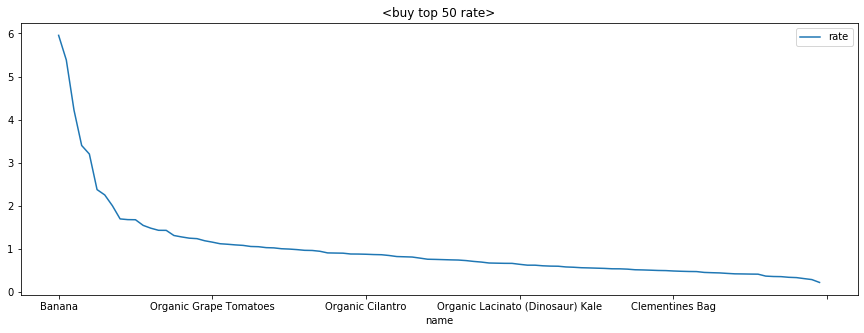

In [497]:
pd.DataFrame(b1.pivot_table('rate', index = 'name', aggfunc = 'sum')).sort_values('rate', ascending = False).plot(figsize=(15,5), title = "<buy top 50 rate>")

In [498]:
# 하위 25% 개 구매이력 삭제됨
print(len(TX_PAST), "/", len(TX_PAST_50))

938005 / 938005


#### 상품분류별 구매 비율
- division 9개, category 21개, name 100개

In [725]:
df_products_info.groupby(['division_name','category_name'])['product_id'].count()

division_name  category_name                
bakery         bread                             1
beverages      refrigerated                      1
               soft drinks                       1
               water seltzer sparkling water     5
canned goods   canned meals beans                1
dairy eggs     butter                            2
               cream                             2
               eggs                              2
               milk                              5
               packaged cheese                   4
               soy lactosefree                   3
deli           fresh dips tapenades              1
               lunch meat                        1
frozen         frozen produce                    2
meat seafood   packaged poultry                  1
pantry         oils vinegars                     1
produce        fresh fruits                     24
               fresh herbs                       3
               fresh vegetables      

produce division 에 상품이 제일 많이 분류되어 있어 왜곡현상으로 보임

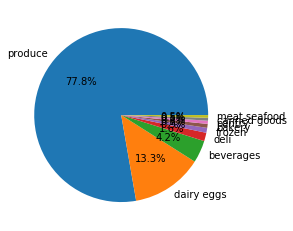

In [726]:
a3 = pd.DataFrame(b1.pivot_table('rate', index = 'division_name', aggfunc = 'sum')).sort_values('rate', ascending = False)
a3_plot=plt.pie(a3.rate, labels= a3.index, autopct = '%.1f%%')

In [727]:
a3

,rate
division_name,
produce,77.753331
dairy eggs,13.264650
beverages,4.150332
deli,1.561917
frozen,0.917564
bakery,0.724338
pantry,0.592996
canned goods,0.533664
meat seafood,0.501207


fresh fruits 카테고리 분류 % : 24 % , 구매 40%  분류% < 구매율 ;; fresh fruit를 많이 구매하는 것으로 보여짐 (그외, 비슷)

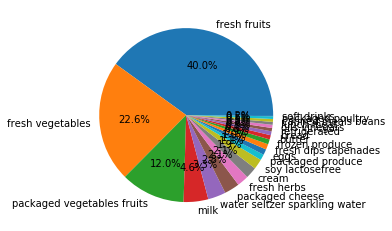

In [728]:
a2 = pd.DataFrame(b1.pivot_table('rate', index = 'category_name', aggfunc = 'sum')).sort_values('rate', ascending = False)
plt11 = plt.pie(a2.rate, labels= a2.index, autopct = '%.1f%%')

In [729]:
a2

,rate
category_name,
fresh fruits,40.015248
fresh vegetables,22.555368
packaged vegetables fruits,11.950426
milk,4.577774
water seltzer sparkling water,3.316900
packaged cheese,2.819999
fresh herbs,2.149091
cream,2.113205
soy lactosefree,1.891749


### 시간대별 구매

> 건수로 하면 그래프 왜곡이 심하기 때문에,, 비율로 대체

In [730]:
TX_PAST.columns

Index(['order_id', 'cstno', 'order_number', 'week_day', 'order_hour',
       'order_interval', 'add_order', 'is_reordered', 'product_id', 'order_rn',
       'add_rn', 'division_name', 'category_name', 'name', 'cnt'],
      dtype='object')

In [731]:
# a3 : divisioin_name / 시간대별 물건 산 건수
a3 = pd.DataFrame(TX_PAST.pivot_table('order_id', index = 'order_hour',columns = 'division_name', aggfunc = 'count'))
# a4 : divisioin_name / 시간대별 물건살확률
a4 = round(a3/pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'division_name', aggfunc = 'count')).values*100,2)
# a5 : category_name / 시간대별 물건 산 건수
a5 = pd.DataFrame(TX_PAST.pivot_table('order_id', index = 'order_hour',columns = 'category_name', aggfunc = 'count'))
# a6 : category_name / 시간대별 물건살확률
a6 = round(a5/pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'category_name', aggfunc = 'count')).values*100,2)
# a7 : division_name / 요일별 물건 산 건수
a7 = pd.DataFrame(TX_PAST.pivot_table('order_id', index = 'week_day',columns = 'division_name', aggfunc = 'count'))
# a8 : division_name / 요일대별 물건살확률
a8 = round(a7/pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'division_name', aggfunc = 'count')).values*100,2)
# a9 : division_name / 요일별 물건 산 건수
a9 = pd.DataFrame(TX_PAST.pivot_table('order_id', index = 'week_day',columns = 'category_name', aggfunc = 'count'))
# a10 : division_name / 요일대별 물건살확률
a10 = round(a9/pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'category_name', aggfunc = 'count')).values*100,2)

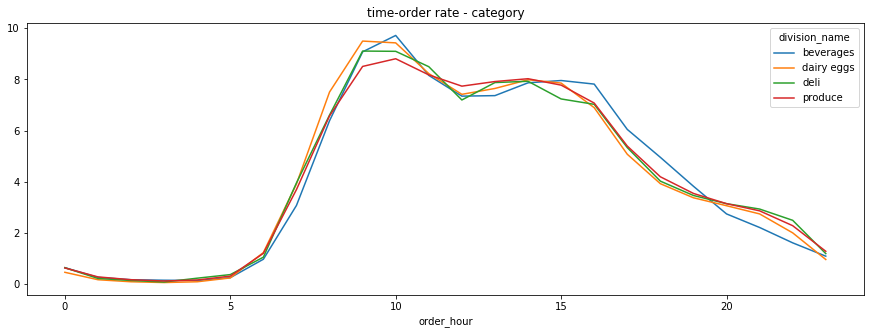

In [732]:
a4.plot(figsize=(15,5), title = "time-order rate - category")

- 10시쯤에 beverage(음료) / 15시 쯤에 canned goods(통조림류)를 많이사는 편

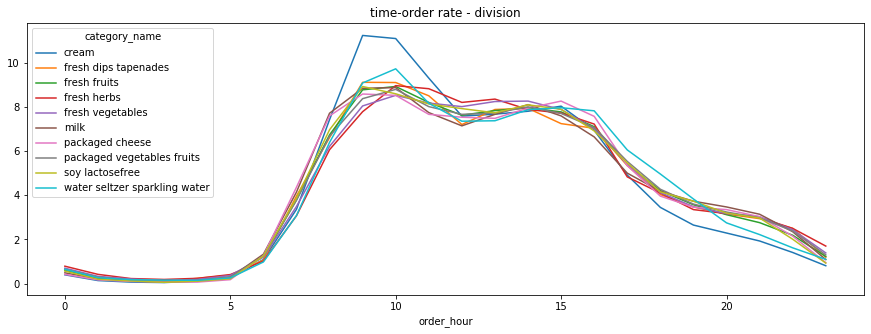

In [733]:
a6.plot(figsize=(15,5), title = "time-order rate - division")

- 10시쯤에 soft_drinks(탄산음료) 특히 많이 삼!

### 요일별 구매

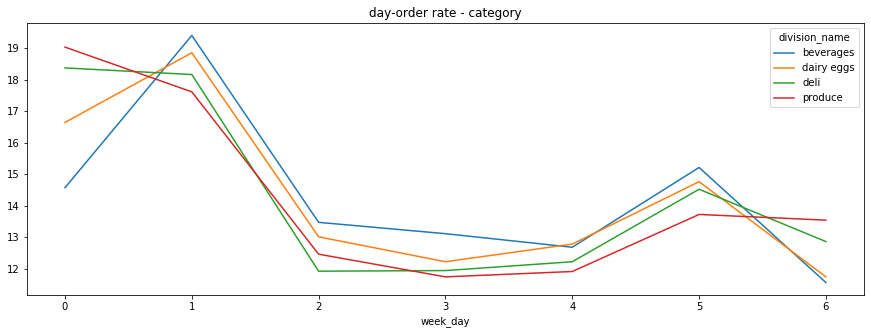

In [734]:
a8.plot(figsize=(15,5), title = "day-order rate - category")

- 0 : 일요일 / 1: 월요일 / 2 : 수요일 / ... / 6 : 토요일
- 주말(토,일)에 특히 meat seafood / canned food 많이삼 : 가족끼리 회식하나? 집에서 밥먹는 사람들이 많아서 그런듯?
- 음료는 평일에 많이사는 편 : 회사강꼐~
- deli(간편식품) : 주말에 높긴 하지만, 그래도 평일에도 고르게 분포
- 구매특성
> -  0,6(토,일) : produce(농산품) > deli(간편식품) > dairy eggs > beverages(음료)
> -   1,2(월,화) : beverages(음료) >  dairy eggs > produce(농산품) = deli(간편식품) 
> -   3,4,5(수,목,금) : beverages(음료) >  dairy eggs > deli(간편식품) > produce(농산품)  

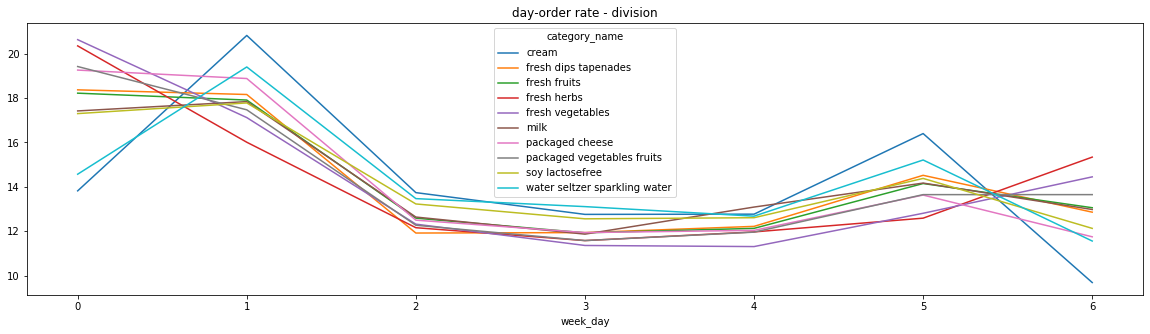

In [735]:
a10.plot(figsize=(20,5), title = "day-order rate - division")

- 0 : 일요일 / 1: 월요일 / 2 : 수요일 / ... / 6 : 토요일
- 위에서 나온 결과랑 비슷한듯.. 
- 아래 요런것들...

In [736]:
a10[a10.values > 22].T

week_day
category_name
cream
fresh dips tapenades
fresh fruits
fresh herbs
fresh vegetables
milk
packaged cheese
packaged vegetables fruits
soy lactosefree


### 재구매율 높은 상품

- 재구매 안한 상품 순위 : max 가 2.58% 로 영향은 미미할듯

In [737]:
# 재구매 안한 고객의 구매 상품 : divisioin_name / 시간대별 물건 산 건수
a11 = pd.DataFrame(TX_PAST[TX_PAST.is_reordered == '0'].pivot_table('order_id', index = ['division_name','category_name','name'], aggfunc = pd.Series.nunique)).sort_values(by = 'order_id', ascending = False)
pd.set_option('max_rows',100)
a12 = a11/ sum(a11.values)*100

In [738]:
a12.describe()

,order_id
count,51.000000
mean,1.960784
std,0.665553
min,0.672509
25%,1.556702
50%,1.933028
75%,2.320679
max,3.833824


- 재구매 많이한 상품 : 바나나 > 우유 > soda > ...
- 상품당 평균 재구매 횟수 : 8.54
- 상위 25%  재구매 횟수 : 10.41

In [739]:
# 재구매 안한 고객의 구매 상품 : divisioin_name / 시간대별 물건 산 건수
a13 = pd.DataFrame(TX_PAST[TX_PAST.is_reordered == '1'].pivot_table(['order_id','cstno'], index = ['division_name','category_name','name'], aggfunc = pd.Series.nunique)).sort_values(by = 'order_id', ascending = False)
# pd.set_option('max_rows',100)
# a12 = a11/ sum(a11.values)*100

In [740]:
a13['고객당평균재구매횟수'] = round( a13['order_id'] / a13['cstno'],2)
pd.set_option('max_rows',30)
a13.sort_values(by = '고객당평균재구매횟수', ascending = False )

cstno  \
division_name category_name                 name                                   
produce       fresh fruits                  Banana                          3147   
                                            Bag of Organic Bananas          3451   
dairy eggs    milk                          Organic Whole Milk              1612   
beverages     water seltzer sparkling water Spring Water                     521   
dairy eggs    milk                          Organic Reduced Fat 2% Milk      604   
...                                                                          ...   
produce       fresh herbs                   Organic Cilantro                1598   
              fresh vegetables              Asparagus                       1397   
              packaged vegetables fruits    Organic Blueberries             2221   
              fresh vegetables              Organic Red Onion               1654   
              fresh herbs                   Organic Italian Parsley Bunch   1644   

                                                                           order_id  \
division_name category_name                 name                                      
produce       fresh fruits                  Banana                            71104   
                                            Bag of Organic Bananas            63601   
dairy eggs    milk                          Organic Whole Milk                27753   
beverages     water seltzer sparkling water Spring Water                       8652   
dairy eggs    milk                          Organic Reduced Fat 2% Milk        9318   
...                                                                             ...   
produce       fresh herbs                   Organic Cilantro                   8648   
              fresh vegetables              Asparagus                          7446   
              packaged vegetables fruits    Organic Blueberries               11806   
              fresh vegetables              Organic Red Onion                  8620   
              fresh herbs                   Organic Italian Parsley Bunch      8487   

                                                                           고객당평균재구매횟수  
division_name category_name                 name                                       
produce       fresh fruits                  Banana                              22.59  
                                            Bag of Organic Bananas              18.43  
dairy eggs    milk                          Organic Whole Milk                  17.22  
beverages     water seltzer sparkling water Spring Water                        16.61  
dairy eggs    milk                          Organic Reduced Fat 2% Milk         15.43  
...                                                                               ...  
produce       fresh herbs                   Organic Cilantro                     5.41  
              fresh vegetables              Asparagus                            5.33  
              packaged vegetables fruits    Organic Blueberries                  5.32  
              fresh vegetables              Organic Red Onion                    5.21  
              fresh herbs                   Organic Italian Parsley Bunch        5.16  

[51 rows x 3 columns]

In [741]:
a13.describe()

,cstno,order_id,고객당평균재구매횟수
count,51.000000,51.000000,51.000000
mean,1729.588235,16141.392157,9.005882
std,710.999921,13313.814396,3.781148
min,521.000000,7446.000000,5.160000
25%,1290.500000,9261.500000,6.380000
50%,1612.000000,11505.000000,7.710000
75%,2059.000000,15797.500000,10.610000
max,3919.000000,71104.000000,22.590000


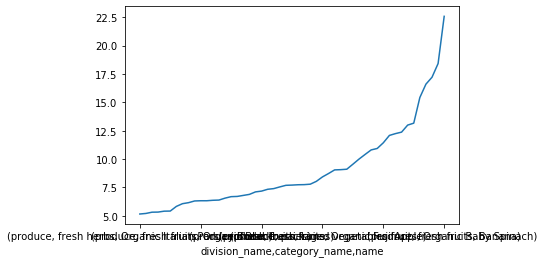

In [742]:
a13['고객당평균재구매횟수'].sort_values().plot()

- 상품별 재구매까지 소요시간에 차이가 있을 지..?
- 재구매까지의 소요시간 0~30사이
- min : 5.19 / max : 6.25 로 큰차이는 없다

In [743]:
TX_PAST["order_interval_int"] =  TX_PAST["order_interval"].apply(pd.to_numeric) 

In [744]:
# order_interval(재구매까지의 소요시간) range
print('min : ',TX_PAST["order_interval_int"].min(), 'max : ', TX_PAST["order_interval_int"].max())

min :  0.0 max :  30.0


In [745]:
a14 = pd.DataFrame(TX_PAST[TX_PAST.is_reordered == '1'].pivot_table('order_interval_int', index = ['division_name','category_name','name'], aggfunc = 'mean')).sort_values(by = 'order_interval_int')

In [746]:
a14.describe()

,order_interval_int
count,51.000000
mean,5.764398
std,0.173518
min,5.450925
25%,5.648709
50%,5.744700
75%,5.860891
max,6.257452


- 상품별 재구매까지소요시간 분포는 얼추 비슷하지만, 그래도 월등히 짧거나 긴 상품들이 있긴함
- 재구매까지 소요시간이 짧은건에 가중치를 줘봐야게따
- 또는 재구매일수별.. 

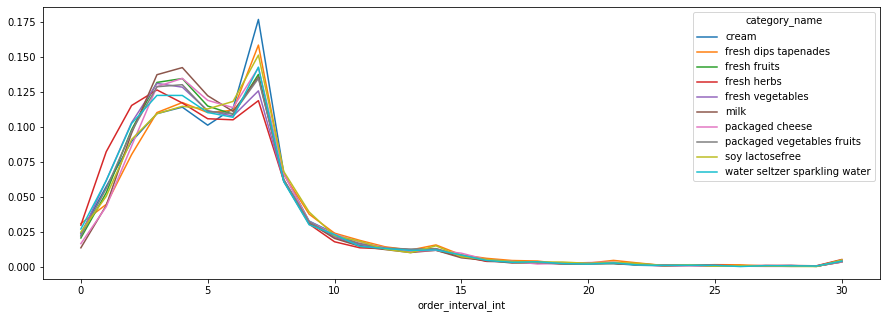

In [747]:
a15 = pd.DataFrame(TX_PAST[TX_PAST.is_reordered == '1'].pivot_table('order_id', columns = ['category_name'], index = 'order_interval_int',aggfunc = 'count')).sort_values(by = 'order_interval_int')
a16 = a15 / pd.DataFrame(TX_PAST[TX_PAST.is_reordered == '1'].pivot_table('order_id', columns = ['category_name'], aggfunc = 'count')).values

a16.plot(figsize=(15,5))

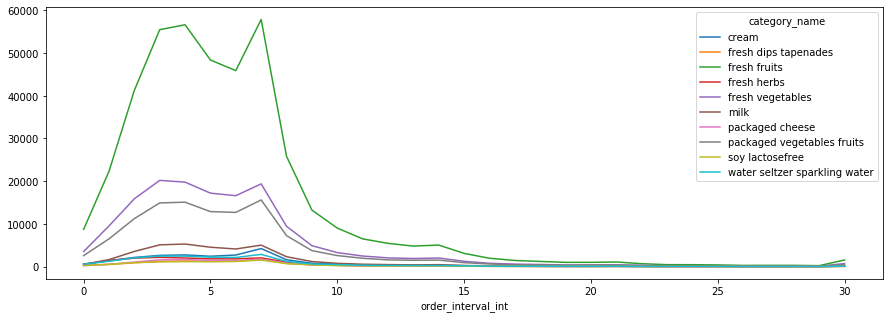

In [748]:
a15.plot(figsize=(15,5))

In [749]:
a3 = pd.DataFrame(TX_PAST.pivot_table('order_id', index = 'order_hour',columns = 'division_name', aggfunc = 'count'))
# a4 : divisioin_name / 시간대별 물건살확률
a4 = round(a3/pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'division_name', aggfunc = 'count')).values*100,2)


In [750]:
a14 = pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'cstno', index = 'order_hour', aggfunc = 'count'))
a14.fillna(0,inplace = True)
a15 = a14/pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'cstno', aggfunc = 'count')).values*100

In [751]:
pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'cstno', aggfunc = 'count')).values

array([[242, 261, 205, ..., 208, 117,  62]])

### 첫구매때 가장 많이 사는 물건

In [753]:
# 재구매 안한 고객의 구매 상품 : divisioin_name / 시간대별 물건 산 건수
a23 = pd.DataFrame(TX_PAST[TX_PAST.is_reordered == '0'].pivot_table('order_id', index = ['division_name','category_name','name'], aggfunc = pd.Series.nunique)).sort_values(by = 'order_id', ascending = False)

In [754]:
a24 = round(a23/len(TX_PAST[TX_PAST.is_reordered == '0'])*100,2)
a24.iloc[0:10,:]

order_id
division_name category_name              name                            
produce       fresh fruits               Organic Strawberries        3.83
                                         Bag of Organic Bananas      3.41
              packaged vegetables fruits Organic Baby Spinach        3.20
              fresh fruits               Banana                      3.12
                                         Organic Hass Avocado        3.02
                                         Limes                       2.79
              packaged vegetables fruits Organic Blueberries         2.66
              fresh vegetables           Organic Garlic              2.66
                                         Organic Yellow Onion        2.60
              fresh fruits               Large Lemon                 2.56

▷ 의외로 첫구매는 바나나가 아님 ㅋ Organic Strawberries > Bag of Organic Banan > Organic Baby Spianch 순

▷ 상품들이 고객들이 많이 담는 것들인 만큼, 안산것들 중에 제일 탑에 잇는애들 추천해 주면 될듯

### 상품 담는 순서 X 구매상품 연관성

> ADD_ORDER(장바구니 담은순서) 컬럼은 구매를 안할 경우, 제외되므로 구매했을 경우의 순서를 재정의해줌 → add_rn

In [755]:
## 예시  
TX_PAST[TX_PAST.order_id == '2538975'].sort_values(by = 'add_order').iloc[:,1:15]

,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,order_rn,add_rn,division_name,category_name,name,cnt
956630,189909,70,0,16,18.0,1,1,21903,68,1,produce,packaged vegetables fruits,Organic Baby Spinach,1
956631,189909,70,0,16,18.0,2,1,13176,68,2,produce,fresh fruits,Bag of Organic Bananas,1
956632,189909,70,0,16,18.0,3,1,44359,68,3,produce,fresh vegetables,Organic Small Bunch Celery,1
956633,189909,70,0,16,18.0,5,1,48679,68,4,produce,fresh vegetables,Organic Garnet Sweet Potato (Yam),1
956486,189909,70,0,16,18.0,7,1,27104,68,5,produce,fresh vegetables,Fresh Cauliflower,1
956487,189909,70,0,16,18.0,11,1,47209,68,6,produce,fresh fruits,Organic Hass Avocado,1
956490,189909,70,0,16,18.0,14,1,37646,68,9,produce,fresh fruits,Organic Gala Apples,1
956491,189909,70,0,16,18.0,19,1,21137,68,10,produce,fresh fruits,Organic Strawberries,1
956500,189909,70,0,16,18.0,34,1,27966,68,15,produce,packaged vegetables fruits,Organic Raspberries,1
956501,189909,70,0,16,18.0,35,1,39928,68,16,produce,fresh fruits,Organic Kiwi,1


In [756]:
a17 = pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'add_rn', index = 'category_name', aggfunc = 'count'))
a17.fillna(0,inplace = True)
a18 = a17/pd.DataFrame(TX_PAST.pivot_table('order_id',index = 'category_name', aggfunc = 'count')).values*100
a18_2 = a17/pd.DataFrame(TX_PAST.pivot_table('order_id',columns = 'add_rn', aggfunc = 'count')).values*100

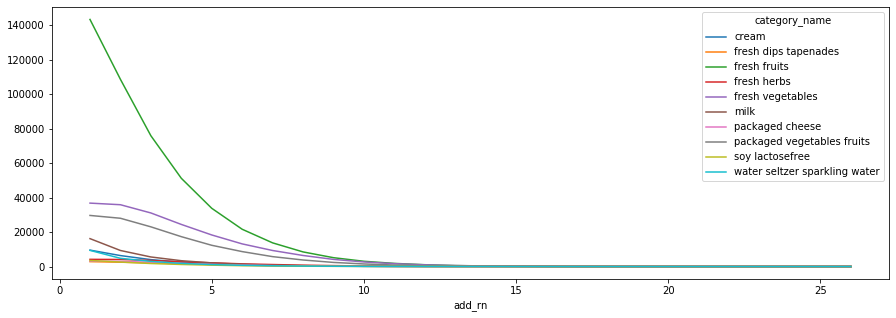

In [757]:
a17.T.plot(figsize=(15,5))

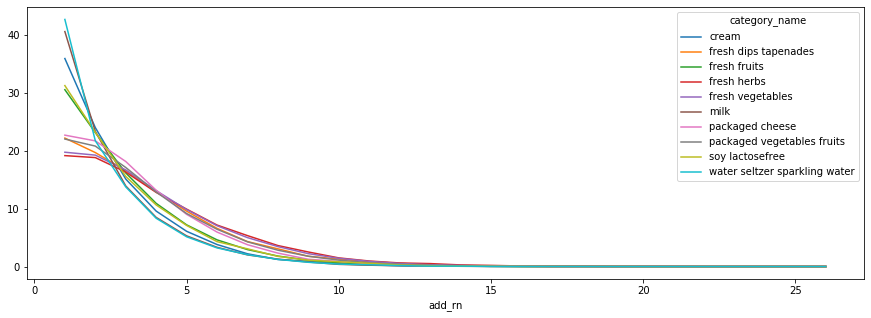

In [758]:
a18.T.plot(figsize=(15,5))

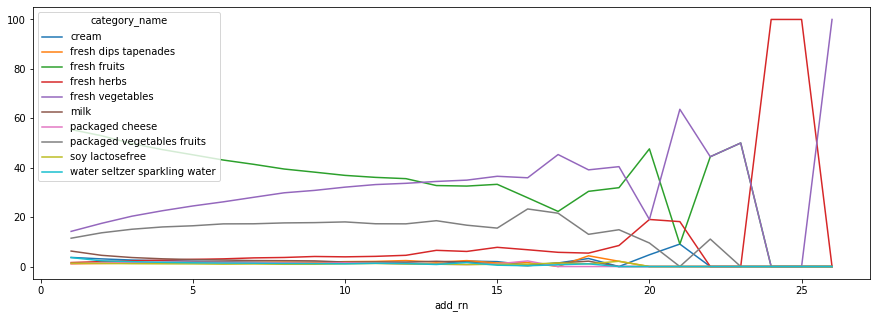

In [759]:
a18_2.T.plot(figsize=(15,5))

> 전체구매횟수 대비 장바구니 담는 순서는 크게 의미 없어 보이나, 3번쨰 이하에 담는 물건의 비중이 높으니걸러보는 걸로

In [760]:
a19 = pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'add_order', index = 'category_name', aggfunc = 'count'))
a19.fillna(0,inplace = True)
a20 = a19/pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'add_order', aggfunc = 'count')).values*100

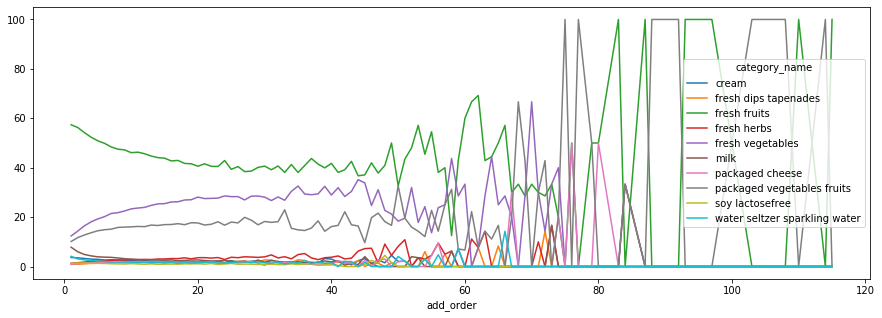

In [761]:
a20.T.plot(figsize=(15,5))

> 전체구매횟수 대비 장바구니 담는 순서(구매안한 제품포함)는 40 이하일떄 분포가  안정적, 이후는 불안정

In [762]:
a21 = pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'add_rn', index = 'add_order', aggfunc = 'count'))
a21.fillna(0,inplace = True)
a22 = a21/pd.DataFrame(TX_PAST.pivot_table('order_id', columns = 'add_rn', aggfunc = 'count')).values*100

### 고객별 상품별 구매횟수 연관성

> 같은상품을 재구매하는 경향이 있어보임, 이에 따라 상위 구매목록 상품 3개정도 가중치를 주면 정확도가 올라갈 것으로 보임(안함,, 시간부족)

In [532]:
# 예측결과와 실제값이 다른 데이터 확인
pred_y.loc[pred_y.y4!=pred_y.real_y].iloc['cstno','y4','real_y']

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [765]:
# 고객 150840 는 실제 무엇을 샀는지 확인
pred_y.loc[pred_y.cstno=='150840'].real_y

1934      Organic Black Beans
4000         Bunched Cilantro
5962      Organic Ginger Root
10574         Original Hummus
11481     Organic Gala Apples
14971          Cucumber Kirby
15281     Organic Blueberries
15983          Organic Garlic
17788                   Limes
20533    Organic Baby Spinach
24421                  Banana
Name: real_y, dtype: object

In [766]:
# 고객 150840 에게 무엇을 추천해줬는지 : 올리브오일 (실제값과 다름)
model2.loc['150840'].sort_values(ascending = False)

name
Extra Virgin Olive Oil             41.690791
Limes                              39.608990
Carrots                            38.707371
Original Hummus                    37.216434
Garlic                             34.863210
                                     ...    
Sparkling Natural Mineral Water    -7.958348
2% Reduced Fat Milk                -8.447225
Spring Water                       -9.728923
Hass Avocados                     -10.866660
Soda                              -15.350952
Name: 150840, Length: 100, dtype: float64

In [767]:
#왜 다른지 과거데이터를 살펴봄
train_X_past.loc[train_X_past.cstno=='150840'].pivot_table('cstno', index=["name"],  aggfunc = 'count').sort_values('cstno', ascending = False).head()

,cstno
name,
Banana,80
Limes,62
Organic Baby Spinach,61
Carrots,55
Extra Virgin Olive Oil,45


- 올리브오일을 많이 사긴 했지만 .. 상위 4개와 비교하면 10개 이상차이남
- 고객별 주문 상품 순위 3위 까지 가중치 주면 좀 더 정확도가 올라가지 않을까

### Current 고객中 첫구매 상품

In [374]:
# 현재테이블에서 처음사는 상품
eda_ty_current.loc[eda_ty_current.is_reordered==0]

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,cnt,division_name,category_name,name
4,3125992,136554,46,4,9,5.0,2,0,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
5,2883377,30098,45,0,15,13.0,19,0,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
29,2839951,69392,48,4,16,11.0,6,0,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
41,2725291,55607,80,5,14,1.0,5,0,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
42,271949,199763,53,5,10,30.0,1,0,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
...,...,...,...,...,...,...,...,...,...,...,...,...
23769,948866,160693,56,0,13,11.0,6,0,1,produce,fresh fruits,Banana
23910,3047089,83923,71,2,11,8.0,2,0,1,produce,fresh fruits,Banana
24020,2211067,74884,86,0,10,4.0,5,0,1,produce,fresh fruits,Banana
24335,1651645,127951,87,6,18,3.0,10,0,1,produce,fresh fruits,Banana


- cstno id : 136554 먼저 알아보자

In [375]:
# 첫 구매 상품 list
eda_ty_current.loc[eda_ty_current.is_reordered==0].loc[eda_ty_current.cstno=='136554']

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,cnt,division_name,category_name,name
4,3125992,136554,46,4,9,5.0,2,0,1,beverages,water seltzer sparkling water,Sparkling Lemon Water


In [337]:
# 과거 구매 목록
train_X_past.loc[train_X_past.cstno=='136554'].pivot_table('cstno', index=["name"],  aggfunc = 'count').sort_values('cstno', ascending = False)

,cstno
name,
Banana,30
Apple Honeycrisp Organic,15
Organic Strawberries,15
Cucumber Kirby,14
Large Alfresco Eggs,10


In [380]:
# 현재 구매 목록
# eda_ty_current.loc[eda_ty_current.cstno=='136554'].pivot_table('cstno', index=["name"],  aggfunc = 'count').sort_values('cstno', ascending = False)
eda_ty_current.loc[eda_ty_current.cstno=='136554']

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,cnt,division_name,category_name,name
4,3125992,136554,46,4,9,5.0,2,0,1,beverages,water seltzer sparkling water,Sparkling Lemon Water
2694,3125992,136554,46,4,9,5.0,1,1,1,dairy eggs,eggs,Large Alfresco Eggs
8624,3125992,136554,46,4,9,5.0,8,1,1,produce,fresh vegetables,Organic Tomato Cluster
13098,3125992,136554,46,4,9,5.0,10,1,1,produce,fresh vegetables,Organic Cucumber
13541,3125992,136554,46,4,9,5.0,11,1,1,produce,packaged vegetables fruits,Seedless Red Grapes
19192,3125992,136554,46,4,9,5.0,9,1,1,produce,fresh fruits,Organic Hass Avocado
20611,3125992,136554,46,4,9,5.0,14,1,1,produce,fresh fruits,Organic Strawberries


In [386]:
# 고객 150840 의 추천목록 中 과거 구매 이력없는 상위제품을 추천한다면?
recomend_list = model2.loc['136554'].sort_values(ascending = False)
base_past = make_user_pivot(TX_PAST)

In [390]:
for i in recomend_list[:].index :
    if base_past.loc['136554'].loc[i] == 0 :
        print(i,end='')
        break

Organic Peeled Whole Baby Carrots

In [391]:
# 추천상품의 추천점수..?
base_past.loc['136554'].loc['Organic Peeled Whole Baby Carrots']

0.0

> 첫구매하는 상품의 경우 추천리스트와 관련이 적어보인다..

In [500]:
# 해당상품의 과거 구매이력 中 특이사항
print("구매고객 :", len(train_X_past.loc[train_X_past.name=='Organic Peeled Whole Baby Carrots'].cstno.unique()))
print("구매횟수 :", train_X_past.loc[train_X_past.name=='Organic Peeled Whole Baby Carrots'].order_id.count())

구매고객 : 1925
구매횟수 : 9240


### 주문서별 구매 특성 상관분석

> 일단, 같은 장바구니내에 상품구매 패턴 분석 : 같은 장바구니에서 사는거 안사는거 분리

In [7]:
TX_PAST_corr = pd.get_dummies(TX_PAST['name'])

In [8]:
TX_PAST_corr["order_id"] = TX_PAST["order_id"] 
TX_PAST_corr["cstno"] = TX_PAST["cstno"] 

In [194]:
TX_PAST_corr.head()

,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions,order_id,cstno
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,583437,141354
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,583437,141354
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,583437,141354
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,583437,141354
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,895214,124514


In [10]:
corr_pivot = pd.pivot_table(TX_PAST_corr, columns = 'order_id', values =TX_PAST_corr.columns, aggfunc = 'sum').T

In [11]:
corr_pivot = corr_pivot.corr()

In [12]:
np.fill_diagonal(corr_pivot.values, 0 )
corr_pivot

,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
100% Raw Coconut Water,0.000000,-0.004125,-0.004336,0.005972,-0.005344,0.028298,-0.035394,-0.014455,-0.010138,-0.015716,...,0.039444,0.011007,0.005351,-0.016195,-0.000300,-0.014117,0.030544,-0.007633,-0.012533,-0.015268
100% Whole Wheat Bread,-0.004125,0.000000,0.003179,0.013898,0.004667,0.031447,0.009050,0.000040,0.002483,-0.009082,...,0.001963,0.000376,-0.015389,0.007770,0.028662,0.001070,-0.001691,-0.002429,0.006440,-0.001633
2% Reduced Fat Milk,-0.004336,0.003179,0.000000,-0.018517,-0.009560,-0.026169,0.032745,0.017810,0.025824,-0.004780,...,-0.002184,-0.002932,-0.009315,-0.002569,-0.009640,-0.002655,-0.012441,0.032059,0.050376,-0.002411
Apple Honeycrisp Organic,0.005972,0.013898,-0.018517,0.000000,0.003990,0.061282,0.003934,0.004557,-0.017962,-0.010728,...,-0.007048,0.013077,-0.010071,-0.000799,0.016780,-0.002632,0.012907,-0.012473,-0.020371,-0.009250
Asparagus,-0.005344,0.004667,-0.009560,0.003990,0.000000,-0.008470,0.013451,0.009774,0.009790,0.027154,...,-0.008518,-0.008676,-0.013206,0.009889,0.007947,0.012839,-0.005073,0.002562,-0.007576,0.026994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unsalted Butter,-0.014117,0.001070,-0.002655,-0.002632,0.012839,-0.022085,0.023394,0.006819,0.005718,0.031682,...,-0.010782,-0.003028,-0.006376,0.005735,0.001068,0.000000,-0.006346,0.003188,0.010517,0.027672
Unsweetened Almondmilk,0.030544,-0.001691,-0.012441,0.012907,-0.005073,0.016771,-0.004774,-0.007192,-0.003021,-0.007226,...,0.001303,0.019656,-0.006913,-0.012880,0.014289,-0.006346,0.000000,-0.008771,-0.001008,-0.001294
Unsweetened Original Almond Breeze Almond Milk,-0.007633,-0.002429,0.032059,-0.012473,0.002562,-0.017134,0.025038,0.004012,0.010404,0.002031,...,-0.005164,0.001259,-0.004042,-0.003844,-0.010572,0.003188,-0.008771,0.000000,0.004815,-0.000304
Whole Milk,-0.012533,0.006440,0.050376,-0.020371,-0.007576,-0.033931,0.011480,0.000967,0.002911,0.001839,...,-0.001798,-0.012121,-0.013938,0.009192,-0.011615,0.010517,-0.001008,0.004815,0.000000,0.001157


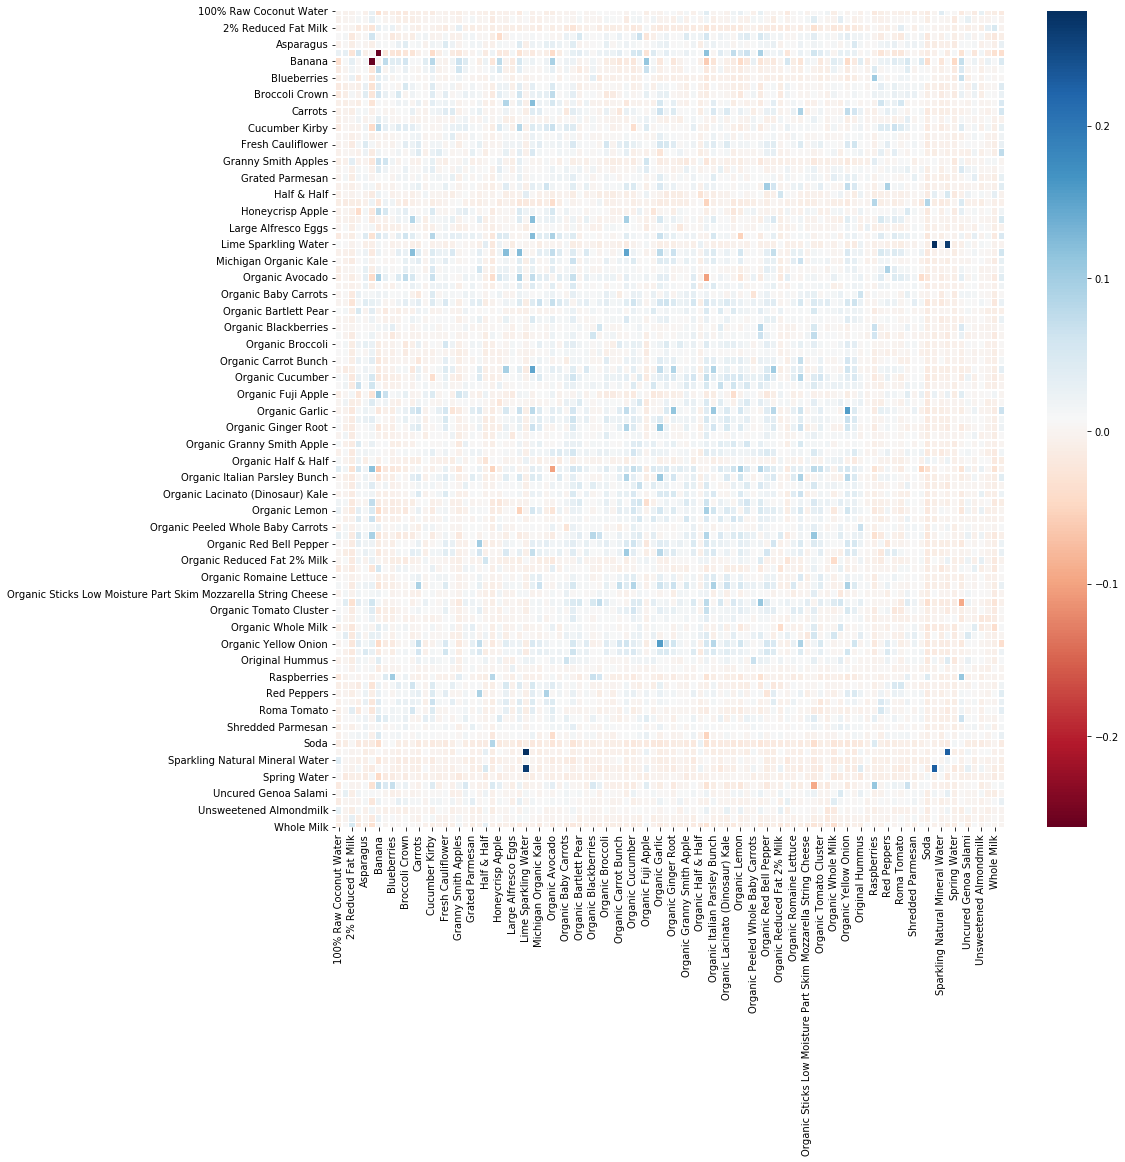

In [13]:
import seaborn as sns
plt.figure(figsize = (15,15))
sns.heatmap(corr_pivot,cmap = 'RdBu', linewidths = 0.5)

▷ 눈아픔.. 계수 높은것만 걸러서 보기

In [14]:
corr_pivot[(corr_pivot.values > 0.2 )|(corr_pivot.values < -0.2 )]

,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
Bag of Organic Bananas,0.028298,0.031447,-0.026169,0.061282,-0.008470,0.000000,-0.259365,-0.024872,-0.024620,-0.031501,...,0.009623,-0.013142,0.012830,-0.031701,0.010594,-0.022085,0.016771,-0.017134,-0.033931,-0.037344
Banana,-0.035394,0.009050,0.032745,0.003934,0.013451,-0.259365,0.000000,0.076082,0.037133,0.040484,...,-0.025143,0.007607,-0.045704,0.072221,0.007376,0.023394,-0.004774,0.025038,0.011480,0.046902
Lime Sparkling Water,0.007852,0.007541,-0.003043,0.007234,-0.007839,-0.008604,0.014973,0.005368,-0.006488,-0.001791,...,0.013913,0.262349,-0.009180,-0.008050,0.015435,0.000180,0.014029,0.009799,-0.004075,-0.001034
Lime Sparkling Water,0.007852,0.007541,-0.003043,0.007234,-0.007839,-0.008604,0.014973,0.005368,-0.006488,-0.001791,...,0.013913,0.262349,-0.009180,-0.008050,0.015435,0.000180,0.014029,0.009799,-0.004075,-0.001034
Sparkling Lemon Water,-0.000513,0.004796,-0.001140,0.002338,-0.012926,-0.005567,0.006570,-0.001910,-0.003319,-0.007785,...,0.004772,0.227769,-0.010284,-0.006108,0.016785,0.001447,0.006688,0.008489,-0.006820,-0.004360
Sparkling Lemon Water,-0.000513,0.004796,-0.001140,0.002338,-0.012926,-0.005567,0.006570,-0.001910,-0.003319,-0.007785,...,0.004772,0.227769,-0.010284,-0.006108,0.016785,0.001447,0.006688,0.008489,-0.006820,-0.004360
Sparkling Water Grapefruit,0.011007,0.000376,-0.002932,0.013077,-0.008676,-0.013142,0.007607,0.002011,-0.005736,-0.009908,...,0.018722,0.000000,-0.017554,-0.009957,0.031142,-0.003028,0.019656,0.001259,-0.012121,-0.009649
Sparkling Water Grapefruit,0.011007,0.000376,-0.002932,0.013077,-0.008676,-0.013142,0.007607,0.002011,-0.005736,-0.009908,...,0.018722,0.000000,-0.017554,-0.009957,0.031142,-0.003028,0.019656,0.001259,-0.012121,-0.009649


▷ 다시...잘안보임... 바나나먼저보자..

In [15]:
corr_pivot.Banana[(corr_pivot.Banana.values > 0.1 )|(corr_pivot.Banana.values < -0.1 )]

Bag of Organic Bananas   -0.259365
Organic Fuji Apple        0.111604
Name: Banana, dtype: float64

▷ 포장된걸 같이 안살 확률이 가장 높고 / fuji apple 을 같이 살 확률이 높음

In [20]:
# 상위 5개 구매 품목 확인해보장
b1.iloc[0:5,:]

,division_name,category_name,name,cnt,rate
99,produce,fresh fruits,Banana,74686,5.95595
98,produce,fresh fruits,Bag of Organic Bananas,67514,5.38401
97,produce,fresh fruits,Organic Strawberries,52917,4.21995
95,produce,fresh fruits,Organic Hass Avocado,42604,3.39752
96,produce,packaged vegetables fruits,Organic Baby Spinach,40112,3.1988


In [21]:
corr_pivot['Bag of Organic Bananas'][(corr_pivot['Bag of Organic Bananas'].values > 0.1 )|(corr_pivot['Bag of Organic Bananas'].values < -0.1 )]

Banana                 -0.259365
Organic Hass Avocado    0.117486
Name: Bag of Organic Bananas, dtype: float64

▷ 포장안된 바나나 같이 안살 확률이 가장 높고 / 하스 avocado를
같이 살 확률이 높음

In [22]:
corr_pivot['Organic Strawberries'][(corr_pivot['Organic Strawberries'].values > 0.1 )|(corr_pivot['Organic Strawberries'].values < -0.1 )]

Organic Raspberries    0.111891
Name: Organic Strawberries, dtype: float64

▷ 라즈베리랑 같이 삼!!

In [23]:
corr_pivot['Organic Hass Avocado'][(corr_pivot['Organic Hass Avocado'].values > 0.1 )|(corr_pivot['Organic Hass Avocado'].values < -0.1 )]

Bag of Organic Bananas    0.117486
Organic Avocado          -0.101835
Name: Organic Hass Avocado, dtype: float64

▷ 그냥 아보카도랑 또 다른 하스 아보카도랑 같이안삼..ㅋ

In [24]:
corr_pivot['Organic Baby Spinach'][(corr_pivot['Organic Baby Spinach'].values > 0.1 )|(corr_pivot['Organic Baby Spinach'].values < -0.1 )]

Series([], Name: Organic Baby Spinach, dtype: float64)

▷ 여기서부터 10% 넘는 상관관계 나오는게 없는걸로 보아.. 더 많은 상품의 장바구니내 상관분석은 어쩌면 의미없을지도.. 

### 고객별 구매 특성 상관분석

In [25]:
corr_pivot2 = pd.pivot_table(TX_PAST_corr, columns = 'cstno', values =TX_PAST_corr.columns, aggfunc = 'sum').T

In [26]:
corr_pivot2 = corr_pivot2.corr()
np.fill_diagonal(corr_pivot2.values, 0 )

▷ 고객별 상관분석은 다 너무 높게 나와서 조치가 필요함...

### 고객별 상관분석(1.2.9) 대신  군집화 해보기

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# feture 설정 
k_means_df = pd.pivot_table(TX_PAST_corr, columns = 'cstno', values =TX_PAST_corr.columns, aggfunc = 'sum').T
# 정규화 진행
scaler = MinMaxScaler()
kmeans_scale = scaler.fit_transform(k_means_df)

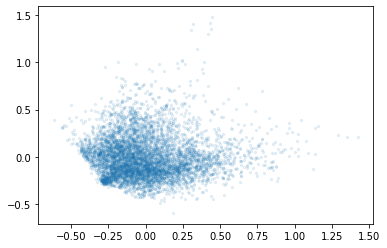

In [31]:
# KMeans 전 성분 분석
pca = PCA()
pca.fit(kmeans_scale)
pc_score = pca.transform(kmeans_scale)
plt.scatter(pc_score[:,0],pc_score[:,1], s= 5, alpha = 0.1)

뭐지 이게..정규화문젠가

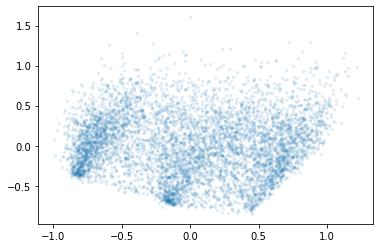

In [32]:
from sklearn.preprocessing import Normalizer
scaler2 = Normalizer('max')
kmeans_scale2 = scaler2.fit_transform(k_means_df)
# min_max 는컬럼별 통계치 이용 // normalizer 은 row마다 정규화 되어 조금더 세분화됨
pca = PCA()
pca.fit(kmeans_scale2)
pc_score2 = pca.transform(kmeans_scale2)
plt.scatter(pc_score2[:,0],pc_score2[:,1], s= 5, alpha = 0.1)

좀 보기 나아진듯.. 이걸로 해야게따 >> 3개정도..?

In [33]:
#일단 3개로
k = 3
k_model = KMeans(n_clusters = k,random_state = 10)
# 정규화된 데이터로 학습
k_model.fit(kmeans_scale2)
# 클러스트링 결과 저장
k_means_df['res'] = k_model.fit_predict(kmeans_scale2)

In [34]:
# 밑에서 예측시에 사용할거에욥
k_means_df.res  

cstno
10000     2
100001    0
100046    2
100071    1
100108    0
         ..
9981      2
99829     2
99887     1
99894     1
99901     1
Name: res, Length: 5859, dtype: int32

In [56]:
kmeans_group = pd.DataFrame(k_means_df,columns = ['res'])

In [58]:
kmeans_group

,res
cstno,
10000,2
100001,0
100046,2
100071,1
100108,0
...,...
9981,2
99829,2
99887,1


> 밑에서 만든 모델로 그룹별 특징 확인하기
> - res 0 : Banana > milk > strawberries > apple > Spinach 
> - res 1 : strawberries >  Spinach > lemon > rasberries
> - res 2 : 포장Banana > strawberries > raspberries > hass avocado > spanich

> 특이한거는 res1은 추천 계수가 그렇게 높지는 않은편

In [64]:
print('res0 : ',model13_0.mean().sort_values(ascending = False).head())
print('\nres1 : ',model13_1.mean().sort_values(ascending = False).head())
print('\nres2 : ',model13_2.mean().sort_values(ascending = False).head())

res0 :  name
Bag of Organic Bananas    6.806592
Organic Strawberries      4.097145
Organic Raspberries       3.949857
Organic Hass Avocado      3.791374
Organic Baby Spinach      3.674660
dtype: float64

res1 :  name
Organic Strawberries    2.181605
Organic Baby Spinach    2.029822
Large Lemon             1.776310
Organic Raspberries     1.763934
Organic Avocado         1.706701
dtype: float64

res2 :  name
Banana                  6.736695
Organic Whole Milk      3.559931
Organic Strawberries    3.292809
Organic Gala Apples     3.013673
Organic Baby Spinach    2.918223
dtype: float64


## F1산출 함수

### F1정의
> F1 Score = 2tp / (2tp + fp + 2fn)

In [455]:
from sklearn.metrics import f1_score
def f1_cst(df, pred, cst) :
    f1 = f1_score(df[df.cstno == cst].real_y, df[df.cstno == cst][pred],average = 'micro')
    
    return f1

In [504]:
def f1_res(df, pred) :
    f = list()
    for i in pred_y.cstno.unique() :
        f.append(f1_cst(df,pred,i))
    
    return np.mean(f)
   

In [505]:
f1_res(pred_y,'y9')

0.17277730049446263

## 협업필터링 모델링

>※ 사용배경 : 가장 보편적으로 사용하는 기법, 데이터가 많을수록 정확도가 올라가는데 과제 데이터가 많아 잘 맞는듯하다
>- 결론 : 채택
>- 이유 : 일치율이 제일 높고, 조건을 세분화 할 수록 더욱 더 높아짐 (데이터 파악이 중요해보임)

### BASE 함수 생성

#### 평점 MATRIX 생성

##### user-item 기반

>※ 기본 가정
>- "평점 = 구매건수"로 가정
>- 고객번호로 구매 상품을 예측하기 때문에 기본적으로 고객기반 MATRIX를 BASE로 함

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

In [44]:
## index = 고객번호 / columns = 상품명 기반의 고객기반 matrix
def make_user_pivot(df) :
    pivot = df.pivot_table('cnt', index = 'cstno', columns = 'name',aggfunc = 'sum')
    pivot.fillna(0,inplace = True)  ## 결측치 제거
    return pivot
## index = 상품명 / columns = 고객번호 기반의 고객기반 matrix
def make_item_pivot(df) :
    pivot = df.pivot_table('cnt', index = 'name', columns = 'cstno',aggfunc = 'sum')
    pivot.fillna(0,inplace = True)  ## 결측치 제거
    return pivot

In [45]:
## 코사인 : 아이템별 유사도값 데이터베이스 생성 : 1에 가까울 수록 유사
def make_item_similarity_df(item_df) :
    similarity_rate = cosine_similarity(item_df,item_df)
    similarity_df = pd.DataFrame(data = similarity_rate,index = item_df.index,columns = item_df.index)
    return similarity_df

In [46]:
## 피어슨 : 아이템별 유사도값 데이터베이스 생성 : 1에 가까울 수록 유사
def make_item_similarity_df_pearson(user_df) :
    similarity_df = user_df.corr(method = 'pearson')
    # similarity_df = pd.DataFrame(data = similarity_rate,index = item_df.index,columns = item_df.index)
    return similarity_df

In [47]:
## user에 item 유사도 매트릭스 부여시, 구매할 확률 array 생성
def predict_rating_arr(a_pivot, similarity_df) : 
    # 고객기반 metrix에 상품별 가중치부여
    rating_arr  = a_pivot.values
    item_sim_arr = similarity_df.values
    # rating_arr : u*i / itme_sim_arr : i*i
    sum_sr = rating_arr @ item_sim_arr
    sum_s_abs = np.array([np.abs(item_sim_arr).sum(axis=1)])
    
    rating_pred = sum_sr / sum_s_abs
    
    return rating_pred

In [48]:
## user에 item 유사도 매트릭스 부여시, 구매할 확률 matrix 생성 (predict_rating_arr 변환)
def predict_rating_matrix(a_pivot, predict_rating_arr) :
    return pd.DataFrame(data = predict_rating_arr, index = a_pivot.index, columns = a_pivot.columns)

In [49]:
## cosine : 위의 과정 한번에
def make_user_prdict_rating_matrix(df) :
    user_pivot = make_user_pivot(df)
    item_pivot = make_item_pivot(df)
    similarity_df = make_item_similarity_df(item_pivot)
    predict_rating = predict_rating_arr(user_pivot, similarity_df)
    predict_rating_mtrx = predict_rating_matrix(user_pivot, predict_rating)
    
    return predict_rating_mtrx

In [50]:
## pearson : 위의 과정 한번에
def make_user_prdict_rating_matrix_p(df) :
    user_pivot = make_user_pivot(df)
    item_pivot = make_item_pivot(df)
    similarity_df = make_item_similarity_df_pearson(user_pivot)
    predict_rating = predict_rating_arr(user_pivot, similarity_df)
    predict_rating_mtrx = predict_rating_matrix(user_pivot, predict_rating)
    
    return predict_rating_mtrx

In [688]:
## index = 고객번호 / columns = 상품명 기반의 고객기반 matrix
def make_hour_pivot(df) :
    pivot = df.pivot_table('cnt', index = 'order_hour', columns = 'name',aggfunc = 'sum')
    pivot.fillna(0,inplace = True)  ## 결측치 제거
    return pivot
## index = 상품명 / columns = 고객번호 기반의 고객기반 matrix
def make_item_hour_pivot(df) :
    pivot = df.pivot_table('cnt', index = 'name', columns = 'order_hour',aggfunc = 'sum')
    pivot.fillna(0,inplace = True)  ## 결측치 제거
    return pivot

In [689]:
## 위의 과정 한번에
def make_hour_prdict_rating_matrix(df) :
    day_pivot = make_hour_pivot(df)
    item_pivot = make_item_hour_pivot(df)
    similarity_df = make_item_similarity_df_pearson(user_pivot)
    predict_rating = predict_rating_arr(day_pivot, similarity_df)
    predict_rating_mtrx = predict_rating_matrix(day_pivot, predict_rating)
    
    return predict_rating_mtrx

##### 예측률 계산 함수 생성

In [51]:
def recommand_user_item(predict_rating_matrix, cstno) : 
    return predict_rating_matrix.loc[cstno].sort_values(ascending = False)[:1].index.values[0]

In [52]:
def recommand_user_item_rate(predict_rating_matrix, cstno) : 
    return predict_rating_matrix.loc[cstno].sort_values(ascending = False)[:1]

In [342]:
## 보기 편리하게 가공
s3 = ''' 
select  a.order_id, a.cstno
        , cast(order_number as integer) as order_number
        , cast(week_day as integer) as week_day
        , cast(order_hour as integer) as order_hour
        , order_interval
        , cast(add_order as integer) as add_order
        , is_reordered
        , a.product_id
        , a.order_rn
        , a.add_rn
        , b.division_name
        , b.category_name
        , b.name
        , 1 as cnt
        , c.order_cnt
        , c.order_id_cnt
        , c.order_prod_cnt
from   (
    select  a.*,
            dense_rank() OVER (PARTITION BY cstno ORDER BY cast(order_number as integer)  ASC)     AS order_rn,
            row_number() OVER (PARTITION BY cstno, order_id ORDER BY cast(add_order as integer) ASC)     AS add_rn
            
    from    l2_jbwc_extnl.train_x_past a
    where 1 = 1 
    order by order_rn, add_rn
) a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id

left join (
select  a.cstno
        ,count(order_id) as order_cnt
        ,count(distinct order_id) as order_id_cnt 
        ,count(distinct a.product_id) as order_prod_cnt
from   l2_jbwc_extnl.train_x_past a

group by a.cstno
)c
on a.cstno = c.cstno'''
TX_PAST = get_df(s3,schema)

In [38]:
sql1 = ''' 
select  a.order_id, cstno
        , cast(order_number as integer) as order_number
        , cast(week_day as integer) as week_day
        , cast(order_hour as integer) as order_hour
        , order_interval
        , cast(add_order as integer) as add_order
        , is_reordered

from    l2_jbwc_extnl.train_x_current a
where 1 = 1 
'''
Train_X_current = get_df(sql1,schema)

sql2 = ''' 
select  a.product_id, b.name
from   l2_jbwc_extnl.train_y a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id
where 1=1

'''
Train_y = get_df(sql2,schema)


In [39]:
pred_y = pd.DataFrame(columns = ['cstno','y','y2','y3','y4','y5','y6','y7','y8','y9','y10'
                                 ,'y11','y12','y13','y14','y15','y16','y17','y18','y19','y20'
                                 ,'y21','y22','y23','y24','y25','y26','y27','y28','y29','y30'
                                ])
pred_y["cstno"] = Train_X_current["cstno"]
pred_y["real_product_id"] = Train_y["product_id"]
pred_y["real_y"] = Train_y["name"]

### 모델 1 : 협업필터링 - 구매건수만 가지고 기본모델

#### user-item 모델 : y 

##### COSINE 모델 적용시 : 11.39% / f1 - 15.14%

In [41]:
TX_PAST_ALL = TX_PAST

In [507]:
model11 = make_user_prdict_rating_matrix(TX_PAST_ALL)
model11_2 = make_user_prdict_rating_matrix(TX_PAST_50)

In [712]:
# 모델 1으로 예측 : 결과 > y 
for j in range(len(Train_X_current)) : 
    pred_y.loc[j].y = recommand_user_item(model11,Train_X_current.loc[j].cstno)

In [510]:
# 모델 1_1으로 예측 : 구매물품 상위 50% 의 물품만 추천 ,상위 50개의 물건 구매 이력이 없으면 기본 모델적용
for j in range(len(Train_X_current)) : 
    try : 
        pred_y.loc[j].y2 = recommand_user_item(model11_2,Train_X_current.loc[j].cstno)
    except : 
        pred_y.loc[j].y2 = recommand_user_item(model11,Train_X_current.loc[j].cstno)


In [512]:
print( 'COSINE user-item기반 : ' , sum(pred_y["y"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y') )
print( 'COSINE user-item기반 - 상위 50상품만 적용 : ' , sum(pred_y["y2"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y2'))

COSINE user-item기반 :  0.11394529970520799 / f1 :  0.15143489387299813
COSINE user-item기반 - 상위 50상품만 적용 :  0.1184490664919751 / f1 :  0.15822216038888728


- 상위 50은 높아지긴 하지만 쓰지말자.... 그래도 더많은 물품을 추천하는 게 나을 듯

##### PEARSON 모델 적용시 : 12.12% / f1 - 16.63%
> 피어슨이 빈도수 차이를 보완해 주어, 조금 더 높은 확률을 보임 : 피어슨 모델로 적용

In [513]:
#pearson
model12 = make_user_prdict_rating_matrix_p(TX_PAST_ALL)

In [514]:
# 모델 1으로 예측 : 결과 > y / ,상위 50개의 물건 구매 이력이 없으면 기본 모델적용
for j in range(len(Train_X_current)) : 
    pred_y.loc[j].y3 = recommand_user_item(model12,Train_X_current.loc[j].cstno)

In [516]:
print( 'user-item기반 pearson : ' , sum(pred_y["y3"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y3'))

user-item기반 pearson :  0.12127415656731085 / f1 :  0.1663615419153656


★ PEARSON 모델이 코사인 모델보다 예측률 높음 ★

##### PEARSON 적용시, kmeans 그룹별 분리  : 12.96% / f1 - 17.84%
> 1.2.10 에서 만든 그룹별로 분리적용해보자잉

In [59]:
TX_PAST_ALL=pd.merge(TX_PAST_ALL,kmeans_group, on = 'cstno', how = 'left')

In [60]:
TX_PAST_ALL.pivot_table('order_id', index = 'res', aggfunc = 'count')/len(TX_PAST_ALL)

,order_id
res,
0,0.377336
1,0.267917
2,0.354747


> 비중 35% / 25% / 39% : 나쁘지 않은듯

In [61]:
model13_0 = make_user_prdict_rating_matrix_p(TX_PAST_ALL[TX_PAST_ALL.res == 0])
model13_1 = make_user_prdict_rating_matrix_p(TX_PAST_ALL[TX_PAST_ALL.res == 1])
model13_2 = make_user_prdict_rating_matrix_p(TX_PAST_ALL[TX_PAST_ALL.res == 2])

In [62]:
Train_X_current = pd.merge(Train_X_current,kmeans_group, on = 'cstno', how = 'left')

In [63]:
Train_X_current.pivot_table('order_id', index = 'res', aggfunc = 'count')/len(Train_X_current)

,order_id
res,
0,0.362021
1,0.287340
2,0.350639


In [225]:
# kmeans model로 예측
for j in range(len(Train_X_current)):
    if Train_X_current.res[j] == 0 :
        pred_y.loc[j].y17 = recommand_user_item(model13_0,Train_X_current.loc[j].cstno)
    elif Train_X_current.res[j] == 1 :
        pred_y.loc[j].y17 = recommand_user_item(model13_1,Train_X_current.loc[j].cstno)    
    else :
        pred_y.loc[j].y17 = recommand_user_item(model13_2,Train_X_current.loc[j].cstno)

In [520]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영 : ' , sum(pred_y["y17"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y17'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영 :  0.12966754012446774 / f1 :  0.17846768192089113


> 나누는게 확률이 좀 높음!!!!, 1.2%p 정도 올라감

### 모델 2 : 협업필터링 - 재구매율이 높은 상품에 가중치 주기
- 재구매율까지 소요되는 시간이 짧을수록 더 많이 구매할 것이라고 가정
- 재구매율이 높은 상품에 가중치 부여

##### PEARSON 적용시 + 가중치 반영   : 12.21% / f1- 16.73%
> 1.2.10 에서 만든 그룹별로 분리적용해보자잉

In [212]:
#안될시 재실행
TX_PAST_ALL2 = TX_PAST
TX_PAST_ALL2["order_interval_int"] =  TX_PAST_ALL2["order_interval"].apply(pd.to_numeric) 

In [213]:
#재구매까지의 소요시간 interval max : 30
print('min interval :',min(TX_PAST_ALL2["order_interval_int"] ),'/ max interval : ', max(TX_PAST_ALL2["order_interval_int"] ))
##invertval 기간이 짧을수록 가중치를 높게 줌 (max:30 - order_interval)
TX_PAST_ALL2["wght_train"] = 30 - TX_PAST_ALL2["order_interval_int"]
TX_PAST_ALL2["wght_cnt"] = 1 + TX_PAST_ALL2["cnt"] * TX_PAST_ALL2["wght_train"]/30

min interval : 0.0 / max interval :  30.0


In [214]:
TX_PAST_ALL2.cnt = TX_PAST_ALL2.wght_cnt

In [215]:
model2 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2)

In [216]:
# 모델 2으로 예측 : 결과 > y
for j in range(len(Train_X_current)) : 
    pred_y.loc[j].y4 = recommand_user_item(model2,Train_X_current.loc[j].cstno)

In [523]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영 : ' , sum(pred_y["y4"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y4'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영 :  0.12217490992466426 / f1 :  0.16734950779068425


★ 가중치 반영한게 더 높음 ★

##### PEARSON 적용시 + 가중치 반영 + kmeans 그룹별 분리  : 12.85% / f1 - 17.71%
> 1.2.10 에서 만든 그룹별로 분리적용해보자잉

In [218]:
TX_PAST_ALL2=pd.merge(TX_PAST_ALL2,kmeans_group, on = 'cstno', how = 'left')
model2_0 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.res == 0])
model2_1 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.res == 1])
model2_2 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.res == 2])

In [219]:
pred_y['y18'] = np.nan

In [221]:
# 모델 3으로 예측
for j in range(len(Train_X_current)):
    if Train_X_current.res[j] == 0 :
        pred_y.y18.loc[j] = recommand_user_item(model2_0,Train_X_current.loc[j].cstno)
    elif Train_X_current.res[j] == 1 :
        pred_y.y18.loc[j] = recommand_user_item(model2_1,Train_X_current.loc[j].cstno)    
    else :
        pred_y.y18.loc[j] = recommand_user_item(model2_2,Train_X_current.loc[j].cstno)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [524]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영/k-means group 반영 : ' , sum(pred_y["y18"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y18'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영/k-means group 반영 :  0.12852112676056338 / f1 :  0.17710099518554082


> 홀랭 얘는 가중치 반영이 별로 효과가 없음.. 높아지긴 하는데...... .. ... ...가중치 반영안한 거랑 크게 차이안남

### 모델 3 : 협업필터링 - 요일 나눠서 모델만들기 → 일월/화수목금토가 12.30%로 가장 높음
- EDA시, 주말과 평일에 사는 물건에 차이가 있었음
- 분포가 다른 요일 나눠서 해보기

#### 주말 / 평일 모델 → 12.06% / f1-16.65%

In [223]:
#model3_1 : 주말모델  / model3_2 = 평일모델
model3_1 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[(TX_PAST_ALL2.week_day == 0) | (TX_PAST_ALL2.week_day == 6 )])
model3_2 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[(TX_PAST_ALL2.week_day != 0) & (TX_PAST_ALL2.week_day != 6 )])

In [224]:
# 모델 3으로 예측
for j in range(len(Train_X_current)):
    if (Train_X_current.week_day[j] == 0) | (Train_X_current.week_day[j] == 6):
        if sum(model3_1.index == Train_X_current.loc[j].cstno) == 0 :     #과거에 주말에 산 경험이 없는 경우 기본모델 적용
            print("평일만",Train_X_current.loc[j].cstno)
            pred_y.y5.loc[j] = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.y5.loc[j] = recommand_user_item(model3_1,Train_X_current.loc[j].cstno)
    else :
        if sum(model3_2.index == Train_X_current.loc[j].cstno) == 0 :     #과거에 주말에만 산 경우 기본모델 적용
            print("주말만",Train_X_current.loc[j].cstno)
            pred_y.y5.loc[j] = recommand_user_item(model2,Train_X_current.loc[j].cstno)
        else :
            pred_y.y5.loc[j] = recommand_user_item(model3_2,Train_X_current.loc[j].cstno)

평일만 117167
평일만 33142
평일만 118728
평일만 118728
평일만 33142
평일만 118728
평일만 33142
평일만 118728
평일만 33142
평일만 33142
평일만 33142
평일만 155864
평일만 155864
평일만 118728
평일만 118728
평일만 33142
평일만 118728
평일만 118728
평일만 118728
평일만 155864
평일만 117167
평일만 118728


In [525]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영 + 주말/평일 분리 : ' , sum(pred_y["y5"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y5'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영 + 주말/평일 분리 :  0.12066000655093351 / f1 :  0.16653768709919128


In [234]:
pred_y['week_day'] = Train_X_current['week_day']

In [235]:
print( '주말 / 평일 예측률 각각 : ' , sum(pred_y[(pred_y.week_day == 0) | (pred_y.week_day == 6) ]["y5"]==pred_y[(pred_y.week_day == 0) | (pred_y.week_day == 6) ]["real_y"])/len(pred_y[(pred_y.week_day == 0) | (pred_y.week_day == 6) ])
     ,sum(pred_y[(pred_y.week_day != 0) & (pred_y.week_day != 6) ]["y5"]==pred_y[(pred_y.week_day != 0) & (pred_y.week_day != 6) ]["real_y"])/len(pred_y[(pred_y.week_day != 0) & (pred_y.week_day != 6) ]))

주말 / 평일 예측률 각각 :  0.10854289940828403 0.1302910052910053


#### 일월 / 화수목금토 → 구매수가 많았던 요일 끼리 묶어서  → 12.30% / f1-16.68%

In [236]:
#10/25 눌 수정 구매량순 일월 / 화수목금토 → 구매수가 많았던 요일 끼리 묶어서
#model3_1 : 주말모델  / model3_2 = 평일모델
model3_3 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[(TX_PAST_ALL2.week_day == 0) | (TX_PAST_ALL2.week_day == 1 )])
model3_4 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[(TX_PAST_ALL2.week_day != 0) & (TX_PAST_ALL2.week_day != 1 )])

In [237]:
# 모델 3으로 예측
for j in range(len(Train_X_current)):
    if (Train_X_current.week_day[j] == 0) | (Train_X_current.week_day[j] == 1):
        if sum(model3_3.index == Train_X_current.loc[j].cstno) == 0 :     #과거에 일월에 산 경험이 없는 경우 기본모델 적용
            pred_y.y6.loc[j] = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.y6.loc[j] = recommand_user_item(model3_3,Train_X_current.loc[j].cstno)
            # print(Train_X_current.week_day[j], ":", Train_X_current.loc[j].cstno)
    else :
        if sum(model3_4.index == Train_X_current.loc[j].cstno) == 0 :     #과거에 일월에만 산 경우 기본모델 적용
            pred_y.y6.loc[j] = recommand_user_item(model2,Train_X_current.loc[j].cstno)
        else :
            pred_y.y6.loc[j] = recommand_user_item(model3_4,Train_X_current.loc[j].cstno)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [526]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영 + 일월/화토 분리 : ' , sum(pred_y["y6"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y6'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영 + 일월/화토 분리 :  0.12307566328201769 / f1 :  0.16682149353379136


In [239]:
pred_y['week_day'] = Train_X_current['week_day']
print( '일월 / 화토 예측률 각각 : ' , sum(pred_y[(pred_y.week_day == 0) | (pred_y.week_day == 1) ]["y6"]==pred_y[(pred_y.week_day == 0) | (pred_y.week_day == 1) ]["real_y"])/len(pred_y[(pred_y.week_day == 0) | (pred_y.week_day == 1) ])
     ,sum(pred_y[(pred_y.week_day != 0) & (pred_y.week_day != 1) ]["y6"]==pred_y[(pred_y.week_day != 0) & (pred_y.week_day != 1) ]["real_y"])/len(pred_y[(pred_y.week_day != 0) & (pred_y.week_day != 1) ]))
pred_y = pred_y.drop(['week_day'],axis=1)

일월 / 화토 예측률 각각 :  0.1145799806887673 0.12831887704429584


> 평균적으로 봤을 때는 두번째(일월/화토) 모델의 예측률이 높으나, 각각의 예측율로 봤을때 평일의 예측률이 높은 편

### 3.2 모델 4 : 협업필터링 - 장바구니 담은 순서 가중치 담기 → 장바구니 담은 순서가 3번째 이상인 것들 모델 
- EDA시, 장바구니에 3번째 이하에 담는 물건의 비중이 높은편

#### add_order 가 32번째 이후에 담긴 물건 → 12.22% / f1 - 16.74%
-  add_order (장바구니 담은순서)가 빠를수록 모형이 안정적 // 뒤에 담은 애들끼리 안중요하다고 가정하고 모형하나 더만들기
-  32번째 이후면 새모형 , 이전이면 기존모형

In [240]:
## 장바구니에 32번째 이후에 담긴 물건
model4_1 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.add_order >= 32])

In [241]:
# 모델 4으로 예측
for j in range(len(Train_X_current)):
    if (Train_X_current.add_order[j] >= 32) :
        if sum(model4_1.index == Train_X_current.loc[j].cstno) == 0 :     #예외처리
            print("32번이상에 장바구니 넣은적 없",Train_X_current.loc[j].cstno)
            pred_y.loc[j].y8 = recommand_user_item(model2,Train_X_current.loc[j].cstno)
        else : 
            pred_y.loc[j].y8 = recommand_user_item(model4_1,Train_X_current.loc[j].cstno) 
    else :
        pred_y.loc[j].y8 = recommand_user_item(model2,Train_X_current.loc[j].cstno)

32번이상에 장바구니 넣은적 없 138549
32번이상에 장바구니 넣은적 없 99500
32번이상에 장바구니 넣은적 없 124949
32번이상에 장바구니 넣은적 없 119610
32번이상에 장바구니 넣은적 없 64606
32번이상에 장바구니 넣은적 없 34077
32번이상에 장바구니 넣은적 없 156059
32번이상에 장바구니 넣은적 없 117658
32번이상에 장바구니 넣은적 없 138549
32번이상에 장바구니 넣은적 없 163618
32번이상에 장바구니 넣은적 없 28510
32번이상에 장바구니 넣은적 없 28510
32번이상에 장바구니 넣은적 없 107105
32번이상에 장바구니 넣은적 없 191191
32번이상에 장바구니 넣은적 없 84308
32번이상에 장바구니 넣은적 없 52121
32번이상에 장바구니 넣은적 없 117658
32번이상에 장바구니 넣은적 없 38930
32번이상에 장바구니 넣은적 없 163618
32번이상에 장바구니 넣은적 없 34077
32번이상에 장바구니 넣은적 없 92370
32번이상에 장바구니 넣은적 없 137159
32번이상에 장바구니 넣은적 없 107105


In [528]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영 / 장바구니 넣은순서 반영 : ' , sum(pred_y["y8"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y8'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영 / 장바구니 넣은순서 반영 :  0.12225679659351457 / f1 :  0.16741838838951878


In [537]:
pred_y['add_order'] = Train_X_current['add_order']
print( '기존모형 32번째이상 / 이하  예측률 각각 : ' 
     , sum(pred_y[pred_y.add_order >= 32 ]["y4"]==pred_y[pred_y.add_order >= 32 ]["real_y"])/len(pred_y[pred_y.add_order >= 32  ]))
print( '세 모형 32번째이상 / 이하  예측률 각각 : ' 
     , sum(pred_y[pred_y.add_order >= 32 ]["y8"]==pred_y[pred_y.add_order >= 32 ]["real_y"])/len(pred_y[pred_y.add_order >= 32  ]))
pred_y = pred_y.drop(['add_order'],axis=1)

기존모형 32번째이상 / 이하  예측률 각각 :  0.038461538461538464
세 모형 32번째이상 / 이하  예측률 각각 :  0.04700854700854701


> 아주 약간~ 높아지는경향이 있음.. 1%..

#### 주문한 물건중 장바구니 순서가3번째 이전에 담긴 물건 → 12.71% / f1 - 17.27%
-  먼저 담을 수록 구매확률이 높고, 중요한 물건이라는 가정하에, 3번쨰 이전에 담은것들은 모형을 따로만든다

In [246]:
Train_X_current['add_rn'] = Train_X_current.groupby('order_id')['add_order'].transform('rank')

In [248]:
## 장바구니에 3번째 이전에 담긴 물건
model4_3 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.add_rn <= 3])

In [249]:
for j in range(len(Train_X_current)):
    if (Train_X_current.add_rn[j] <= 3 ) :
        if sum(model4_3.index == Train_X_current.loc[j].cstno) == 0 :     #예외처리
            print("3번이상에 장바구니 넣은적 없",Train_X_current.loc[j].cstno)
            pred_y.loc[j].y9 = recommand_user_item(model2,Train_X_current.loc[j].cstno)
        else : 
            pred_y.loc[j].y9 = recommand_user_item(model4_3,Train_X_current.loc[j].cstno) 
    else :
        pred_y.loc[j].y9 = recommand_user_item(model2,Train_X_current.loc[j].cstno)

In [529]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영 / 장바구니 넣은순서 반영 v2 : ' , sum(pred_y["y9"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y9'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영 / 장바구니 넣은순서 반영 v2 :  0.12712905339010808 / f1 :  0.17277730049446263


In [539]:
pred_y['add_rn'] = Train_X_current['add_rn']
print( '기존모형 3번째안에 주문한 건 예측률 각각 : ' 
      , sum(pred_y[pred_y.add_rn <= 3 ]["y4"]==pred_y[pred_y.add_rn <= 3 ]["real_y"])/len(pred_y[pred_y.add_rn <= 3 ]))
print( '새모형 3번째안에 주문한 건 예측률 각각 : ' 
      , sum(pred_y[pred_y.add_rn <= 3 ]["y9"]==pred_y[pred_y.add_rn <= 3 ]["real_y"])/len(pred_y[pred_y.add_rn <= 3 ]))
pred_y = pred_y.drop(['add_rn'],axis=1)

기존모형 3번째안에 주문한 건 예측률 각각 :  0.17192982456140352
새모형 3번째안에 주문한 건 예측률 각각 :  0.1802545579635363


> 얘도 아주 약간~ 높아지는경향이 있음.. 1%..

##### PEARSON 적용시 + 장바구니 3번째 이하 + kmeans 그룹별 분리  : 13.10% /f1 - 17.97%
> 1.2.10 에서 만든 그룹별로 분리적용해보자잉

In [656]:
model43_0 = make_user_prdict_rating_matrix_p(TX_PAST_ALL[(TX_PAST_ALL.add_rn <= 3) & (TX_PAST_ALL.res == 0)])
model43_1 = make_user_prdict_rating_matrix_p(TX_PAST_ALL[(TX_PAST_ALL.add_rn <= 3) & (TX_PAST_ALL.res == 1)])
model43_2 = make_user_prdict_rating_matrix_p(TX_PAST_ALL[(TX_PAST_ALL.add_rn <= 3) & (TX_PAST_ALL.res == 2)])

In [657]:
for j in range(len(Train_X_current)):
    if Train_X_current.res[j] == 0 :
        if (Train_X_current.add_rn[j] <= 3 ) :
            pred_y.loc[j].y19 = recommand_user_item(model43_0,Train_X_current.loc[j].cstno)     
        else :
            pred_y.loc[j].y19 = recommand_user_item(model13_0,Train_X_current.loc[j].cstno)
    elif Train_X_current.res[j] == 1 :
        if (Train_X_current.add_rn[j] <= 3 ) :
            pred_y.loc[j].y19 = recommand_user_item(model43_1,Train_X_current.loc[j].cstno)     
        else :
            pred_y.loc[j].y19 = recommand_user_item(model13_1,Train_X_current.loc[j].cstno)
    elif Train_X_current.res[j] == 2 :
        if (Train_X_current.add_rn[j] <= 3 ) :
            pred_y.loc[j].y19 = recommand_user_item(model43_2,Train_X_current.loc[j].cstno)     
        else :
            pred_y.loc[j].y19 = recommand_user_item(model13_2,Train_X_current.loc[j].cstno)        
    else : 
        pred_y.loc[j].y19 = recommand_user_item(model2,Train_X_current.loc[j].cstno)        

In [658]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영 / k-means : ' , sum(pred_y["y19"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y19'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영 / k-means :  0.13105961349492304 / f1 :  0.17977364895266465


In [541]:
pred_y['add_rn'] = Train_X_current['add_rn']
print( '3번째이상 / 모델별 예측률 이하 예측률 각각 : ' 
      , sum(pred_y["y19"]==pred_y["real_y"])/len(pred_y)
      , sum(pred_y[pred_y.add_rn <= 3 ]["y19"]==pred_y[pred_y.add_rn <= 3 ]["real_y"])/len(pred_y[pred_y.add_rn <= 3 ]))
pred_y = pred_y.drop(['add_rn'],axis=1)

3번째이상 / 모델별 예측률 이하 예측률 각각 :  0.13142810350474943 0.1889232886136911


▷ 확실히 모델 나누는  게 효과가 좋음~

### 모델 5 : 협업필터링 - 시간대 나누기 → 12.217%
- EDA시, 시간대 별로 구매 물품의 차이가 있었음

#### 새벽/아침/오후/저녁 모델 → 12.217% / f1- 16.25%

In [257]:
## train데이터 가공
## 시간대 나누기 order_hour : 0~6시 새벽 / 7~11시 아침 / 12~17시 점심 / 18~23 저녁 
TX_PAST_ALL2["order_hour_int"] =  TX_PAST_ALL2["order_hour"].apply(pd.to_numeric) 
conditions = [(TX_PAST_ALL2.order_hour_int <= 5),(TX_PAST_ALL2.order_hour_int <= 11),(TX_PAST_ALL2.order_hour_int <= 17),(TX_PAST_ALL2.order_hour_int <= 23)]
values = ['새벽','아침','오후','저녁']
TX_PAST_ALL2['order_hour_adj'] = np.select(conditions ,values)

In [258]:
## train current 데이터 가공
## 시간대 나누기 order_hour : 0~6시 새벽 / 7~11시 아침 / 12~17시 점심 / 18~23 저녁 
Train_X_current["order_hour_int"] =  Train_X_current["order_hour"].apply(pd.to_numeric) 
conditions = [(Train_X_current.order_hour_int <= 5),(Train_X_current.order_hour_int <= 11),(Train_X_current.order_hour_int <= 17),(Train_X_current.order_hour_int <= 23)]
values = ['새벽','아침','오후','저녁']
Train_X_current['order_hour_adj'] = np.select(conditions ,values)

In [259]:
## 시간대별 모델 : 0~5 새벽 / 6~11 아침 / 12~17 오후 / 18~23 저녁
model5_1 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.order_hour_adj == '새벽'])
model5_2 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.order_hour_adj == '아침'])
model5_3 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.order_hour_adj == '오후'])
model5_4 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.order_hour_adj == '저녁'])

In [261]:

for j in range(len(Train_X_current)):
    if (Train_X_current.order_hour_adj[j] == '새벽') :
        if sum(model5_1.index == Train_X_current.loc[j].cstno) == 0 :     #과거에 새벽에 산 경험이 없는 경우 기본모델 적용
            pred_y.loc[j].y10 = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.loc[j].y10 = recommand_user_item(model5_1,Train_X_current.loc[j].cstno)
            # print(Train_X_current.week_day[j], ":", Train_X_current.loc[j].cstno)
    elif (Train_X_current.order_hour_adj[j] == '아침') :
        if sum(model5_2.index == Train_X_current.loc[j].cstno) == 0 :     #과거에 아침에 산 경험이 없는 경우 기본모델 적용
            pred_y.loc[j].y10 = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.loc[j].y10 = recommand_user_item(model5_2,Train_X_current.loc[j].cstno)        
    elif (Train_X_current.order_hour_adj[j] == '오후') :
        if sum(model5_3.index == Train_X_current.loc[j].cstno) == 0 :     #과거에 오후에 산 경험이 없는 경우 기본모델 적용
            pred_y.loc[j].y10 = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.loc[j].y10 = recommand_user_item(model5_3,Train_X_current.loc[j].cstno)        
    elif (Train_X_current.order_hour_adj[j] == '저녁') :
        if sum(model5_4.index == Train_X_current.loc[j].cstno) == 0 :     #과거에 저녁에 산 경험이 없는 경우 기본모델 적용
            pred_y.loc[j].y10 = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.loc[j].y10 = recommand_user_item(model5_4,Train_X_current.loc[j].cstno)        
    else :
        pred_y.loc[j].y10 = recommand_user_item(model2,Train_X_current.loc[j].cstno)

In [542]:
print( 'item기반/재구매까지 소요시간이 짧을 때 가중치 반영 / 시간대별분리 : ' , sum(pred_y["y10"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y10'))

item기반/재구매까지 소요시간이 짧을 때 가중치 반영 / 시간대별분리 :  0.11926793318047822 / f1 :  0.16252212816962372


In [266]:
pred_y['order_hour_adj'] = Train_X_current['order_hour_adj']
print( '새벽/아침/오후/저녁 예측률 각각 : ' 
      , sum(pred_y[pred_y.order_hour_adj == '새벽' ]["y10"]==pred_y[pred_y.order_hour_adj == '새벽']["real_y"])/len(pred_y[pred_y.order_hour_adj == '새벽' ])
      , sum(pred_y[pred_y.order_hour_adj == '아침' ]["y10"]==pred_y[pred_y.order_hour_adj == '아침']["real_y"])/len(pred_y[pred_y.order_hour_adj == '아침' ])
      , sum(pred_y[pred_y.order_hour_adj == '오후' ]["y10"]==pred_y[pred_y.order_hour_adj == '오후']["real_y"])/len(pred_y[pred_y.order_hour_adj == '오후' ])
      , sum(pred_y[pred_y.order_hour_adj == '저녁' ]["y10"]==pred_y[pred_y.order_hour_adj == '저녁']["real_y"])/len(pred_y[pred_y.order_hour_adj == '저녁' ]))
pred_y = pred_y.drop(['order_hour_adj'],axis=1)

새벽/아침/오후/저녁 예측률 각각 :  0.10852713178294573 0.12701252236135957 0.11982166078394947 0.10284261613126877


> 시간대 나눠도 예측률은 거기서거기... 아침이 쫌 높은편이긴 함

### 모델 6 : 협업필터링 - 주문한 상품수가 적은 것들을 예외치로 보고 모델 따로 만들기 → 12.14% / f1 - 16.60%
- EDA시, 1~3가지 상품만 주구장창 구매한 고객들이 많이 있었음. 예외치로 보고 모델 따로만들기

In [267]:
## 보기 편리하게 가공
s4 = ''' 
select  a.cstno
        ,count(order_id) as order_cnt
        ,count(distinct order_id) as order_id_cnt 
        ,count(distinct name) as order_prod_cnt
from   l2_jbwc_extnl.train_x_past a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id

group by a.cstno
'''
cst_prd_select = get_df(s4,schema)

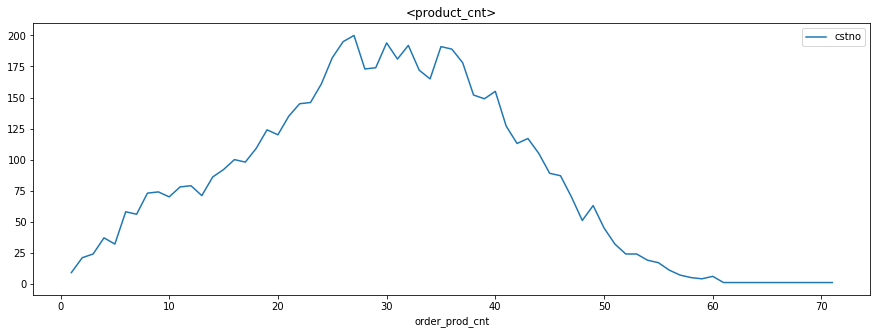

In [268]:
# 고객별 주문상품품목수 분포
cst_prd_select.pivot_table('cstno', index = 'order_prod_cnt',  aggfunc = 'count').plot(figsize=(15,5), title = "<product_cnt>")

In [270]:
Train_X_current = pd.merge(Train_X_current,cst_prd_select, on = 'cstno', how = 'left')

In [271]:
len(TX_PAST_ALL2[(TX_PAST_ALL2.order_prod_cnt <= 5 )])/len(TX_PAST_ALL2)

0.008202734989298006

In [272]:
len(TX_PAST_ALL2[(TX_PAST_ALL2.order_prod_cnt <= 49 )& (TX_PAST_ALL2.order_prod_cnt >= 6 )])/len(TX_PAST_ALL2)

0.934271259645351

In [285]:
##
model6_1 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[(TX_PAST_ALL2.order_prod_cnt > 5)&(TX_PAST_ALL2.order_prod_cnt <= 50)])
model6_2 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.order_prod_cnt <= 5])
model6_3 = make_user_prdict_rating_matrix_p(TX_PAST_ALL2[TX_PAST_ALL2.order_prod_cnt > 50])

In [286]:

for j in range(len(Train_X_current)):
    if (Train_X_current.order_prod_cnt[j] <= 5):
        if sum(model6_2.index == Train_X_current.loc[j].cstno) == 0 :     
            pred_y.y12.loc[j] = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.y12.loc[j] = recommand_user_item(model6_2,Train_X_current.loc[j].cstno)
    elif (Train_X_current.order_prod_cnt[j] > 50) :
        if sum(model6_3.index == Train_X_current.loc[j].cstno) == 0 :     
            pred_y.y12.loc[j] = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.y12.loc[j] = recommand_user_item(model6_3,Train_X_current.loc[j].cstno)               
    else :
        if sum(model6_1.index == Train_X_current.loc[j].cstno) == 0 :     
            pred_y.y12.loc[j] = recommand_user_item(model2,Train_X_current.loc[j].cstno) 
        else :
            pred_y.y12.loc[j] = recommand_user_item(model6_1,Train_X_current.loc[j].cstno)               

In [543]:
print( 'item기반/구매물건수별 분리 / 시간대별분리 : ' , sum(pred_y["y12"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y12'))

item기반/구매물건수별 분리 / 시간대별분리 :  0.12139698657058631 / f1 :  0.16607232780126668


In [291]:
pred_y['order_prod_cnt'] = Train_X_current['order_prod_cnt']
print( '구매물건건수 예측률 각각 1/2/3/50개이상 /3~49개 : ' 
      , sum(pred_y[pred_y.order_prod_cnt <= 1 ]["y12"]==pred_y[pred_y.order_prod_cnt <= 1]["real_y"])/len(pred_y[pred_y.order_prod_cnt<=1 ])
      , sum(pred_y[pred_y.order_prod_cnt <= 2 ]["y12"]==pred_y[pred_y.order_prod_cnt <= 2]["real_y"])/len(pred_y[pred_y.order_prod_cnt<=2 ])
      , sum(pred_y[pred_y.order_prod_cnt <= 3 ]["y12"]==pred_y[pred_y.order_prod_cnt <= 3]["real_y"])/len(pred_y[pred_y.order_prod_cnt<=3 ])
      , sum(pred_y[(pred_y.order_prod_cnt >3)&(pred_y.order_prod_cnt <=50) ]["y12"]==pred_y[(pred_y.order_prod_cnt >3)&(pred_y.order_prod_cnt <=50)]["real_y"])/len(pred_y[(pred_y.order_prod_cnt >3)&(pred_y.order_prod_cnt <=50)])
      , sum(pred_y[pred_y.order_prod_cnt >50 ]["y12"]==pred_y[pred_y.order_prod_cnt >50]["real_y"])/len(pred_y[pred_y.order_prod_cnt>50 ])
      , sum(pred_y[(pred_y.order_prod_cnt >3)&(pred_y.order_prod_cnt <=50) ]["y12"]==pred_y[(pred_y.order_prod_cnt >3)&(pred_y.order_prod_cnt <=50)]["real_y"])/len(pred_y[(pred_y.order_prod_cnt >3)&(pred_y.order_prod_cnt <=50)])
      )
pred_y = pred_y.drop(['order_prod_cnt'],axis=1)

구매물건건수 예측률 각각 1/2/3/50개이상 /3~49개 :  0.9 0.717948717948718 0.6103896103896104 0.12157080591402444 0.07724867724867725 0.12157080591402444


In [ ]:
 1.0 0.84 0.6981 0.6889 0.6917 0.0708 0.1269

### 모델 7 : 협업필터링 - 고객별 is_reorderd == 0 일때 , 이제껏 과거에 안산 물건 추천
> 구매건수 기준 구매율 순위 top 100 중에, 이제껏 안산 것 중에 순위 젤 높은 것

In [639]:
# 구매건수 기준 구매율 순위 내림차순 : EDA 중 1.2.1.1
b1

,division_name,category_name,name,cnt,rate
99,produce,fresh fruits,Banana,74686,5.95595
98,produce,fresh fruits,Bag of Organic Bananas,67514,5.38401
97,produce,fresh fruits,Organic Strawberries,52917,4.21995
95,produce,fresh fruits,Organic Hass Avocado,42604,3.39752
96,produce,packaged vegetables fruits,Organic Baby Spinach,40112,3.1988
...,...,...,...,...,...
14,produce,fresh vegetables,Garlic,4210,0.335733
4,dairy eggs,soy lactosefree,Unsweetened Original Almond Breeze Almond Milk,4122,0.328715
24,produce,fresh vegetables,Roma Tomato,3829,0.30535
15,dairy eggs,milk,2% Reduced Fat Milk,3547,0.282861


In [554]:
notbuy_cstno = pd.pivot_table(TX_PAST_corr, columns = 'cstno', values =TX_PAST_corr.columns, aggfunc = 'sum').T

In [555]:
notbuy_cstno

,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
cstno,,,,,,,,,,,,,,,,,,,,,
10000,0,41,0,0,0,6,30,0,0,0,...,0,1,1,0,2,0,0,0,1,1
100001,20,0,0,4,0,41,0,0,3,0,...,3,0,0,0,0,0,0,0,0,1
100046,0,0,0,0,1,2,21,3,0,0,...,0,2,0,2,0,0,0,0,0,0
100071,0,0,0,0,0,6,0,0,0,0,...,0,0,4,0,0,0,2,0,0,0
100108,0,0,0,14,0,20,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,0,0,15,0,0,0,45,0,0,0,...,0,6,0,0,0,0,0,0,0,0
99829,0,1,0,0,0,1,34,0,8,1,...,0,0,0,0,1,1,0,16,0,12
99887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [618]:
def reorder_if_0(current_df, rank_prod, cst_prod_matrix )  : 
    res = pd.DataFrame(columns = ['cst','rank','pred_prod'] )
    k = 0                   
    for j in current_df[current_df.is_reordered == '0'].cstno : 
        
        for i in range(100) : 
            if cst_prod_matrix[cst_prod_matrix.index == j][rank_prod.iloc[i,2]].iloc[0] == 0 :
                break
            tmp = [j,i,rank_prod.iloc[i,2]]
            # res.cst[k] = j
            # res.rank[k] = i
            # res.pred_prod[k] = rank_prod.iloc[i,2]
            res.append(tmp)
    return res        

In [621]:
def reorder_if_0(cstno, rank_prod, cst_prod_matrix )  : 
    for i in range(100) : 
        if cst_prod_matrix[cst_prod_matrix.index == cstno][rank_prod.iloc[i,2]].iloc[0] == 0 :
            break
    return rank_prod.iloc[i,2]        

In [633]:

for j in range(len(Train_X_current)):
    if(Train_X_current.is_reordered[j] == '0'):
        pred_y.y11.loc[j] = reorder_if_0(Train_X_current.cstno[j], b1, notbuy_cstno)
    else :
        pred_y.y11.loc[j] = 'aa'

In [638]:
pred_y['is_reordered'] = Train_X_current['is_reordered']
print(
    '기존모델 : '
    ,sum(pred_y[pred_y.is_reordered == '0']["y19"]==pred_y[pred_y.is_reordered =='0']["real_y"])/len(pred_y[pred_y.is_reordered=='0' ])
    
    ,'새모델 : '
    ,sum(pred_y[pred_y.is_reordered == '0']["y11"]==pred_y[pred_y.is_reordered =='0']["real_y"])/len(pred_y[pred_y.is_reordered=='0' ])
      )
pred_y = pred_y.drop(['is_reordered'],axis=1)

기존모델 :  0.0 새모델 :  0.037578288100208766


> 그래도 3%는 맞춤... ㅋ

### 모델 7 : 협업필터링 - 결합 → 13.14% / f1 - 18.02%
- 예측률이 높앗던 모델들 사용해서 결합

In [651]:

#  재구매여부 ==0 > 3번 이하에 장바구니에 넣은 물건들 모델 >구매품목이 5개 미만인 모델 > 평일 > 토 > 기본
for j in range(len(Train_X_current)):
    if(Train_X_current.is_reordered[j] == '0'):
        pred_y.y7.loc[j] = reorder_if_0(Train_X_current.cstno[j], b1, notbuy_cstno)
    if (Train_X_current.add_rn[j] <= 3 ) :
        if Train_X_current.res[j] == 0 :
            pred_y.loc[j].y7 = recommand_user_item(model43_0,Train_X_current.loc[j].cstno)
            # a.loc[j].y = '장바구니3번째이하_모델0'
        elif Train_X_current.res[j] == 1 :
            pred_y.loc[j].y7 = recommand_user_item(model43_1,Train_X_current.loc[j].cstno)
            # a.loc[j].y = '장바구니3번째이하_모델1'
        elif Train_X_current.res[j] == 2 :
            pred_y.loc[j].y7 = recommand_user_item(model43_2,Train_X_current.loc[j].cstno)
            # a.loc[j].y = '장바구니3번째이하_모델2'
    elif (Train_X_current.order_prod_cnt[j] <= 5):
        if sum(model6_2.index == Train_X_current.loc[j].cstno) != 0 :     #구매품목이 5개 미만인 모델
            pred_y.loc[j].y7 = recommand_user_item(model6_2,Train_X_current.loc[j].cstno)
            # a.loc[j].y = '5개미만'
    elif (Train_X_current.week_day[j] != 0) & (Train_X_current.week_day[j] != 6):
        if sum(model3_2.index == Train_X_current.loc[j].cstno) != 0 :     #과거에 주말에만 산 경우 기본모델 적용
            pred_y.loc[j].y7 = recommand_user_item(model3_2,Train_X_current.loc[j].cstno)            
            # a.loc[j].y = '평일'
    elif (Train_X_current.week_day[j] != 0) & (Train_X_current.week_day[j] != 1):    
        if sum(model3_4.index == Train_X_current.loc[j].cstno) != 0 :     #과거에 일월에만 산 경우 기본모델 적용
            pred_y.loc[j].y7 = recommand_user_item(model3_4,Train_X_current.loc[j].cstno)
            # a.loc[j].y = '토'
    else :
        pred_y.loc[j].y7 = recommand_user_item(model2,Train_X_current.loc[j].cstno)  
        # a.loc[j].y = '기본'

In [653]:
print( '모델 결합 : ' , sum(pred_y["y7"]==pred_y["real_y"])/len(pred_y), '/ f1 : ' , f1_res(pred_y,'y7'))

모델 결합 :  0.13142810350474943 / f1 :  0.18020102377200056


---

## 로지스틱 모델링

>※ 사용배경 : 이전에 종목별 구매 여부를 판단하는 모형을 만들었기에, 100개 아이템 별로 구매 여부(1,0)의 모델링을 해보면 어떨까?
>- 결론 : 실패
>- 이유 : 상품별(100)개 모델의 구매여부(0,1) 일치확률이 90% 가 넘었음, 그러나 전체 예측률은 10% 미만
>>       알고보니, 모든 항목을 구매안한다고 예측했기 때문에 항목별 일치확률은 90% 였던 것
>>       이후 상관관계를 보니.. 박살나있었다.. (덕분에,, 데이터를 좀 더 뜯어보고 아이디어를 내게 됐다..)

### BASE 함수 생성

#### 상품별 구매여부함수 만들기

> - 상품 = 'Banana'이면 Banana 컬럼에 1 / 다른상품에 대한 컬럼이면 Banana 컬럼에 0 부여

In [718]:
def make_prod_col(df, prd_name) :
    df[prd_name] = df.name.apply(lambda x : 1 if x == prd_name else 0)
    return df

#### 전처리 : 변수별 형변환 컬럼 만들기

> - 로지스틱 모델링  시, 숫자형 변수가 필요하므로 '문자>숫자' 변수 변환함수 만들기
> -  order_interval_int 는 첫구매시 결측치가 있으므로, 없을 경우 -1 부여

In [717]:
def make_change_col(df) :
    df["order_interval_int"] =  df["order_interval"].apply(pd.to_numeric)
    df['order_interval_int'] = df['order_interval_int'].fillna(-1).astype('int64')
    df["is_reordered_int"] =  df["is_reordered"].apply(pd.to_numeric)

In [716]:
def make_dummy_col(df, col_names) :    
    df2 = pd.get_dummies(df, columns = col_names)
    return df2 

#### 모델링

In [719]:
#1 paclkage 로드
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#2 모델링 함수 만들기
def make_logit_model(df, prd_name, features) : 
    model = LogisticRegression()
    scaler = StandardScaler()
    buy = df[prd_name]
    #3 학습/평가 분리
    train_features, test_features, train_labels, test_labels = train_test_split(features, buy)
    #4 데이터정규화
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)
    #5 모델생성
    model.fit(train_features, train_labels)
    
    return model

In [720]:
# 예측값 받는 함수 만들기
def make_logit_result(df, prd_name, model,features) : 
    df['prd_' + str(prd_name)] = model.predict(features)
    df['prba_' + str(prd_name)] = model.predict_proba(features)[:,1]
    
    return df    


### 모델 1 : 로지스틱 
> 'week_day','order_hour','order_interval_int','is_reordered_int' 기본형 적용시

In [ ]:
Train_X_current2 = Train_X_current

In [721]:
TX_PAST5 = train_X_past
# TX_PAST5 테이블에 상품별 구매여부 컬럼 만들기
for i in df_products_info.name : 
    make_prod_col(TX_PAST5, i)
# 전처리 - 형변환
make_change_col(TX_PAST5)
make_change_col(Train_X_current2)

In [722]:
features = TX_PAST5[['week_day','order_hour','order_interval_int','is_reordered_int']]

In [723]:
#4 현재 데이터정규화
current_features = Train_X_current2[['week_day','order_hour','order_interval_int','is_reordered_int']]
c_scaler = StandardScaler()
current_list = c_scaler.fit_transform(current_features)

In [724]:
for i in df_products_info.name :
    mod = make_logit_model(TX_PAST5, i, features)
    make_logit_result(Train_X_current2, i, mod, current_features)    
    print(i, '완료')

Sparkling Lemon Water 완료
Organic Broccoli Florets 완료
Pure Irish Butter 완료
Organic Sticks Low Moisture Part Skim Mozzarella String Cheese 완료
Unsweetened Original Almond Breeze Almond Milk 완료
Organic Romaine Lettuce 완료
Bartlett Pears 완료
Whole Milk 완료
Organic Reduced Fat Milk 완료
Unsalted Butter 완료
Soda 완료
Organic Carrot Bunch 완료
Granny Smith Apples 완료
Shredded Parmesan 완료
Garlic 완료
2% Reduced Fat Milk 완료
Organic Bartlett Pear 완료
100% Raw Coconut Water 완료
Organic Black Beans 완료
Organic Broccoli 완료
Grape White/Green Seedless 완료
Orange Bell Pepper 완료
Clementines Bag 완료
Organic Grade A Free Range Large Brown Eggs 완료
Roma Tomato 완료
Large Alfresco Eggs 완료
Uncured Genoa Salami 완료
Broccoli Crown 완료
Jalapeno Peppers 완료
Organic Navel Orange 완료
Sparkling Natural Mineral Water 완료
Red Onion 완료
Organic Lacinato (Dinosaur) Kale 완료
Grated Parmesan 완료
Bunched Cilantro 완료
Lime Sparkling Water 완료
Organic Reduced Fat 2% Milk 완료
Organic D'Anjou Pears 완료
Small Hass Avocado 완료
Unsweetened Almondmilk 완료
Organic 

In [725]:
use_col = []
for i in df_products_info.name :
    use_col.append('prba_' + str(i))

In [727]:
import re
for i in range(len(Train_X_current2)) : 
    # print(i)
    # print(Train_X_current.columns[Train_X_current.loc[i].values == max(Train_X_current[use_col].loc[i])][0])
    Train_X_current2["logit_y"] = re.sub( 'prba_','',Train_X_current2.columns[Train_X_current2.loc[i].values == max(Train_X_current2[use_col].loc[i])][0])

In [731]:
Train_X_current2['name'] = pred_y.real_y

In [732]:
print( 'logit모델 반영시 : ' , sum(Train_X_current2["name"]==Train_X_current2["logit_y"])/len(Train_X_current2))

logit모델 반영시 :  0.05875368490009827


In [733]:
pd.DataFrame(Train_X_current2.pivot_table('order_id', index = 'logit_y', aggfunc = 'count'))

,order_id
logit_y,
Bag of Organic Bananas,24424


### 모델 2 : 로지스틱 → 돌려본 결과 다 바나나 나와서 다시 돌리진 않았습니당..
> 'week_day','order_hour','order_interval_int' dummy 변수로 적용시

In [713]:
TX_PAST6 = train_X_past
Train_X_current3 = Train_X_current

In [714]:
## train데이터 가공
## 시간대 나누기 order_hour : 0~6시 새벽 / 7~11시 아침 / 12~17시 점심 / 18~23 저녁 
TX_PAST6["order_hour_int"] =  TX_PAST6["order_hour"].apply(pd.to_numeric) 
conditions = [(TX_PAST6.order_hour_int <= 5),(TX_PAST6.order_hour_int <= 11),(TX_PAST6.order_hour_int <= 17),(TX_PAST6.order_hour_int <= 23)]
values = ['새벽1','아침2','오후3','저녁4']
TX_PAST6['order_hour_adj'] = np.select(conditions ,values)

In [735]:
TX_PAST6 = make_dummy_col(TX_PAST6,['week_day','order_hour_adj'])

In [ ]:
for i in df_products_info.name : 
    make_prod_col(TX_PAST6, i)

# 전처리 - 형변환
make_change_col(TX_PAST6)
features2 = TX_PAST6[['week_day_0','week_day_1','week_day_2','week_day_3','week_day_4','week_day_5','week_day_6',
                     'order_hour_adj_새벽1','order_hour_adj_아침2','order_hour_adj_오후3','order_hour_adj_저녁4',
                     'order_interval_int']]    

In [ ]:
TX_PAST6.iloc[:,10:23]

In [ ]:
#4 현재 데이터 가공
Train_X_current3= Train_X_current
Train_X_current3["order_hour_int"] = Train_X_current3["order_hour"].apply(pd.to_numeric)

conditions2 = [(Train_X_current3.order_hour_int <= 5),(Train_X_current3.order_hour_int <= 11),(Train_X_current3.order_hour_int <= 17),(Train_X_current3.order_hour_int <= 23)]
values2 = ['새벽1','아침2','오후3','저녁4']
Train_X_current3['order_hour_adj'] = np.select(conditions2 ,values2)

# 더미만들기
Train_X_current3 = make_dummy_col(Train_X_current3,['week_day','order_hour_adj'])

# 전처리 - 형변환
make_change_col(Train_X_current2)

In [ ]:
Train_X_current3.columns

In [ ]:
current_features2 = Train_X_current3[['week_day_0','week_day_1','week_day_2','week_day_3','week_day_4','week_day_5','week_day_6',
                                     'order_hour_adj_새벽1','order_hour_adj_아침2','order_hour_adj_오후3','order_hour_adj_저녁4',
                                     'order_interval_int']]
c_scaler2 = StandardScaler()
current_list2 = c_scaler2.fit_transform(current_features2)

In [ ]:
for i in df_products_info.name :
    mod2 = make_logit_model(TX_PAST6, i, features2)
    make_logit_result(Train_X_current3, i, mod2, current_features2)    
    print(i, '완료')

In [ ]:
use_col2 = []
for i in df_products_info.name :
    use_col2.append('prba_' + str(i))

In [ ]:
import re
for i in range(len(Train_X_current2)) : 
    # print(i)
    # print(Train_X_current.columns[Train_X_current.loc[i].values == max(Train_X_current[use_col].loc[i])][0])
    Train_X_current3["logit_y"] = re.sub( 'prba_','',Train_X_current3.columns[Train_X_current3.loc[i].values == max(Train_X_current3[use_col2].loc[i])][0])

In [ ]:
Train_X_current3['name'] = pred_y.real_y

In [ ]:
print( 'logit모델 반영시 : ' , sum(Train_X_current2["name"]==Train_X_current2["logit_y"])/len(Train_X_current2))

In [ ]:
pd.DataFrame(Train_X_current3.pivot_table('order_id', index = 'logit_y', aggfunc = 'count'))

In [ ]:
a2 = Train_X_current3.groupby(by = 'name').count().order_id / len(Train_X_current2) *100
a2.sort_values(ascending = False)

## (추가)협업필터링 모델링(SVD)
돌리진 말아주시고,, 시도정도만 봐주시길.. 다른 노트에서 시도한 후 붙여넣어놨기 때문입니다.. : )

>※ 잠재요인분석
>※ 사용배경 : 분석 초반에 시도해본 것으로, 예측률을 올리는 방법을 찾다가 무작정 시도해봄
>- 결론 : 실패 (그냥.. 이런시도도 해봤다..만 봐주세요..)
>- 이유 : 결과를 볼 수 없음.. 오래 코드가 돌아가다가 멈춤..

In [ ]:
#221016
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

In [ ]:
# 잠재요인구하기
# cstno * item 구매빈도
txpp_R = pd.DataFrame(tx_past_product.pivot_table('order_id',index = 'cstno',columns = 'name', aggfunc = 'count'))
# 고객별 구매확률
R = np.array(round(txpp_R/ pd.DataFrame(tx_past_product.pivot_table('order_id',columns = 'cstno', aggfunc = 'count')).T.values,4))

In [ ]:
num_users, num_items = R.shape
K=3

# P, Q 행렬크기 지정하고 정규분포 가진 임의의값으로 입력
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users,K))
Q = np.random.normal(scale=1./K, size=(num_items,K))

In [ ]:
# 잠재요인 행렬 오차값 함수
from sklearn.metrics import mean_squared_error 

def get_rmse(R, P, Q, non_zeros) : 
    error = 0
    # a = pd.DataFrame( columns =  ["mse", "rsme"])
    #내적 예측 R 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse
    # return round(rmse,2)

In [ ]:
# R>0 인 행위치, 열위치 값을 non_zeros 리스트에 저장
non_zeros = [(i,j,R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0]
# setting
steps = 10 
learning_rate = 0.01
r_lambda = 0.01

In [ ]:
# SGD 기법으로 P와 Q 매트릭스 업데이트
for step in range(steps) : 
    for i, j, r in non_zeros : 
        # 실제 값과 예측 값의 차이인 오류 값 구함
        eij = r - np.dot(P[i, :], Q[j, :].T)
        # Regularizaation을 반영한 SGD 업데이트 공식 적용
        P[i, :] = P[i, :] + learning_rate*(eij * Q[j,:] - r_lambda*P[i, :])
        Q[j, :] = Q[j, :] + learning_rate*(eij * P[i,:] - r_lambda*Q[j, :])
        # print(P[i, :],Q[j, :]) 
        
        
        rmse = get_rmse(R, P, Q, non_zeros)
        
            
        
        # if(step == 0) :
        #     print("### iteration step : ", step, " i: ",i, " j : ",j, " r :", r,  "rmse : ", rmse)
            
        # a = a+1

In [ ]:
### 실패, 결과가 안나옴

## 결과 : TEST_DATA 생성 → 협업필터링 적용


### data불러오기

In [654]:
## 보기 편리하게 가공
s6 = ''' 
select  a.order_id, a.cstno
        , cast(order_number as integer) as order_number
        , cast(week_day as integer) as week_day
        , cast(order_hour as integer) as order_hour
        , order_interval
        , cast(add_order as integer) as add_order
        , is_reordered
        , a.product_id
        , a.order_rn
        , a.add_rn
        , b.division_name
        , b.category_name
        , b.name
        , 1 as cnt
        , c.order_cnt
        , c.order_id_cnt
        , c.order_prod_cnt
from   (
    select  a.*,
            dense_rank() OVER (PARTITION BY cstno ORDER BY cast(order_number as integer)  ASC)     AS order_rn,
            row_number() OVER (PARTITION BY cstno, order_id ORDER BY cast(add_order as integer) ASC)     AS add_rn
            
    from    l2_jbwc_extnl.test_x_past a
    where 1 = 1 
    order by order_rn, add_rn
) a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id

left join (
select  a.cstno
        ,count(order_id) as order_cnt
        ,count(distinct order_id) as order_id_cnt 
        ,count(distinct a.product_id) as order_prod_cnt
from   l2_jbwc_extnl.test_x_past a

group by a.cstno
)c
on a.cstno = c.cstno
'''
TEST_PAST = get_df(s6,schema)

In [697]:
s7 = ''' 
select  a.order_id, cstno
        , cast(order_number as integer) as order_number
        , cast(week_day as integer) as week_day
        , cast(order_hour as integer) as order_hour
        , order_interval
        , cast(add_order as integer) as add_order
        , is_reordered

from    l2_jbwc_extnl.test_x_current a
where 1 = 1 
'''
TEST_X_current = get_df(s7,schema)

In [690]:
## 보기 편리하게 가공
s8 = ''' 
select  a.cstno
        ,count(order_id) as order_cnt
        ,count(distinct order_id) as order_id_cnt 
        ,count(distinct name) as order_prod_cnt
from   l2_jbwc_extnl.test_x_past a
left join  l2_jbwc_extnl.products_info b
on     a.product_id = b.product_id

group by a.cstno
'''
cst_prd_select2 = get_df(s8,schema)

In [659]:
pred_test_y = pd.DataFrame(columns = ['cstno','y'])
pred_test_y["cstno"] = TEST_X_current["cstno"]

In [665]:
# 상품 별 구매횟수 : top100 list -up
d1 = pd.DataFrame(columns = ["division_name","category_name","name","cnt"])
d1["division_name"] =  df_products_info["division_name"]
d1["category_name"] =  df_products_info["category_name"]
d1["name"] =  df_products_info["name"]
group_txpp2 = TEST_PAST.groupby(['name']).count()

j = 0
for i in df_products_info.name : # i = 물건이름 string
    d1.cnt.loc[j] = group_txpp2[group_txpp2.index == i].order_id[0]
    j = j+1

d1= d1.sort_values(by = 'cnt', ascending = False)

In [676]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

TEST_PAST_corr = pd.get_dummies(TEST_PAST['name'])
TEST_PAST_corr["order_id"] = TEST_PAST["order_id"] 
TEST_PAST_corr["cstno"] = TEST_PAST["cstno"] 

In [679]:
# feture 설정 
k_means_df2 = pd.pivot_table(TEST_PAST_corr, columns = 'cstno', values =TEST_PAST_corr.columns, aggfunc = 'sum').T
scaler3 = Normalizer('max')
kmeans_scale3 = scaler3.fit_transform(k_means_df2)# min_max 는컬럼별 통계치 이용 // normalizer 은 row마다 정규화 되어 조금더 세분화됨

,res
cstno,
100041,1
100103,1
100165,0
100270,2
100359,0
...,...
99897,2
999,1
99915,0


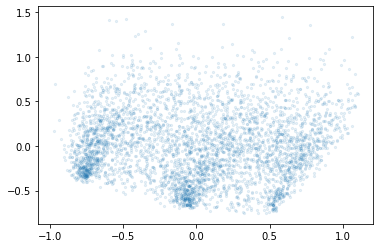

In [681]:
pca = PCA()
pca.fit(kmeans_scale3)
pc_score3 = pca.transform(kmeans_scale3)
plt.scatter(pc_score3[:,0],pc_score3[:,1], s= 5, alpha = 0.1)
#일단 3개로
k = 3
k_model2 = KMeans(n_clusters = k,random_state = 10)
# 정규화된 데이터로 학습
k_model2.fit(kmeans_scale3)
# 클러스트링 결과 저장
k_means_df2['res'] = k_model2.fit_predict(kmeans_scale3)
# 밑에서 예측시에 사용할거에욥
k_means_df2.res  
kmeans_group2 = pd.DataFrame(k_means_df2,columns = ['res'])
kmeans_group2

In [684]:
notbuy_cstno2 = pd.pivot_table(TEST_PAST_corr, columns = 'cstno', values =TEST_PAST_corr.columns, aggfunc = 'sum').T

In [682]:
TEST_PAST_ALL = TEST_PAST
TEST_PAST_ALL=pd.merge(TEST_PAST_ALL,kmeans_group2, on = 'cstno', how = 'left')
TEST_PAST_ALL2 = TEST_PAST
TEST_PAST_ALL2=pd.merge(TEST_PAST_ALL2,kmeans_group2, on = 'cstno', how = 'left')
TEST_PAST_ALL2["order_interval_int"] =  TEST_PAST_ALL2["order_interval"].apply(pd.to_numeric) 
TEST_PAST_ALL2["wght_train"] = 30 - TEST_PAST_ALL2["order_interval_int"]
TEST_PAST_ALL2["wght_cnt"] = 1 + TEST_PAST_ALL2["cnt"] * TX_PAST_ALL2["wght_train"]/30
TEST_PAST_ALL2.cnt = TEST_PAST_ALL2.wght_cnt

In [698]:
TEST_X_current['add_rn'] = TEST_X_current.groupby('order_id')['add_order'].transform('rank')
TEST_X_current = pd.merge(TEST_X_current,cst_prd_select2, on = 'cstno', how = 'left')
TEST_X_current = pd.merge(TEST_X_current,kmeans_group2, on = 'cstno', how = 'left')

In [699]:
TEST_X_current

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,add_rn,order_cnt,order_id_cnt,order_prod_cnt,res
0,3384204,37987,38,5,16,13.0,9,1,4.0,113,35,30,2
1,2578612,169022,38,6,10,7.0,4,1,3.0,274,36,29,0
2,188887,200090,45,5,16,30.0,5,1,3.0,73,36,7,2
3,646772,149416,39,1,13,13.0,15,1,8.0,161,36,27,1
4,300214,113836,42,3,10,17.0,1,1,1.0,147,36,42,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16121,2047884,57077,46,5,15,8.0,2,1,1.0,121,40,21,0
16122,567625,83592,43,4,12,0.0,1,1,1.0,57,40,9,0
16123,596442,157740,49,6,10,3.0,2,1,1.0,107,41,20,0
16124,671102,92043,43,4,10,10.0,1,1,1.0,201,41,32,0


### 모델 생성하기

In [683]:
t_model43_0 = make_user_prdict_rating_matrix_p(TEST_PAST_ALL[(TEST_PAST_ALL.add_rn <= 3) & (TEST_PAST_ALL.res == 0)])
t_model43_1 = make_user_prdict_rating_matrix_p(TEST_PAST_ALL[(TEST_PAST_ALL.add_rn <= 3) & (TEST_PAST_ALL.res == 1)])
t_model43_2 = make_user_prdict_rating_matrix_p(TEST_PAST_ALL[(TEST_PAST_ALL.add_rn <= 3) & (TEST_PAST_ALL.res == 2)])
t_model6_2 = make_user_prdict_rating_matrix_p(TEST_PAST_ALL2[TEST_PAST_ALL2.order_prod_cnt <= 5])
t_model3_2 = make_user_prdict_rating_matrix_p(TEST_PAST_ALL2[(TEST_PAST_ALL2.week_day != 0) & (TEST_PAST_ALL2.week_day != 6 )])
t_model3_4 = make_user_prdict_rating_matrix_p(TEST_PAST_ALL2[(TEST_PAST_ALL2.week_day != 0) & (TEST_PAST_ALL2.week_day != 1 )])
t_model2 = make_user_prdict_rating_matrix_p(TEST_PAST_ALL2)

### 모델링

In [701]:
#  재구매여부 ==0 > 3번 이하에 장바구니에 넣은 물건들 모델 >구매품목이 5개 미만인 모델 > 평일 > 토 > 기본
for j in range(len(TEST_X_current)):
    if(TEST_X_current.is_reordered[j] == '0'):
        pred_test_y.y.loc[j] = reorder_if_0(TEST_X_current.cstno[j], d1, notbuy_cstno2)
    if (TEST_X_current.add_rn[j] <= 3 ) :
        if TEST_X_current.res[j] == 0 :
            pred_test_y.loc[j].y = recommand_user_item(t_model43_0,TEST_X_current.loc[j].cstno)
            # a.loc[j].y = '장바구니3번째이하_모델0'
        elif TEST_X_current.res[j] == 1 :
            pred_test_y.loc[j].y = recommand_user_item(t_model43_1,TEST_X_current.loc[j].cstno)
            # a.loc[j].y = '장바구니3번째이하_모델1'
        elif TEST_X_current.res[j] == 2 :
            pred_test_y.loc[j].y = recommand_user_item(t_model43_2,TEST_X_current.loc[j].cstno)
            # a.loc[j].y = '장바구니3번째이하_모델2'
    elif (TEST_X_current.order_prod_cnt[j] <= 5):
        if sum(t_model6_2.index == TEST_X_current.loc[j].cstno) != 0 :     #구매품목이 5개 미만인 모델
            pred_test_y.loc[j].y = recommand_user_item(t_model6_2,TEST_X_current.loc[j].cstno)
            # a.loc[j].y = '5개미만'
    elif (TEST_X_current.week_day[j] != 0) & (TEST_X_current.week_day[j] != 6):
        if sum(t_model3_2.index == TEST_X_current.loc[j].cstno) != 0 :     #과거에 주말에만 산 경우 기본모델 적용
            pred_test_y.loc[j].y = recommand_user_item(t_model3_2,TEST_X_current.loc[j].cstno)            
            # a.loc[j].y = '평일'
    elif (TEST_X_current.week_day[j] != 0) & (TEST_X_current.week_day[j] != 1):    
        if sum(t_model3_4.index == TEST_X_current.loc[j].cstno) != 0 :     #과거에 일월에만 산 경우 기본모델 적용
            pred_test_y.loc[j].y = recommand_user_item(t_model3_4,TEST_X_current.loc[j].cstno)
            # a.loc[j].y = '토'
    else :
        pred_test_y.loc[j].y = recommand_user_item(t_model2,TEST_X_current.loc[j].cstno)  
        # a.loc[j].y = '기본'

In [705]:
pred_test_y = pred_test_y.drop(['cstno'],axis=1)

In [707]:
pred_test_y

,y
0,100% Raw Coconut Water
1,Lime Sparkling Water
2,Half & Half
3,Sparkling Lemon Water
4,Orange Bell Pepper
...,...
16121,Granny Smith Apples
16122,Banana
16123,Half & Half
16124,Banana


### 결과 저장

In [709]:
pred_test_y.to_csv('./test_y.csv')